# Settings

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.metrics import mean_absolute_error, r2_score
#import category_encoders as ce

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor

In [2]:
sns.set()

pd.set_option("display.max_columns", None)
pd.set_option('display.float_format', '{:,.2f}'.format)
pd.set_option('display.max_colwidth', 120)
pd.set_option('display.max_rows', 500)

# Functions

In [3]:
def plot_results(train, test, fittedvalues, forecast, title):
    
    fig, axs = plt.subplots(1,2,figsize=(16,6), sharey=True,gridspec_kw={"width_ratios": (.55, .45)})
        
    fittedvalues.plot(color='green', ax=axs[0], label='Fitted Values')
    train.plot(color='grey', ax=axs[0], label ='Given Train Data')
    
    r2 = np.round(r2_score(train, fittedvalues),2)
    mae = np.round(mean_absolute_error(train, fittedvalues),2)

    axs[0].set_title(f'Fitted Values\nR2={r2}, MAE={mae}', fontsize=14)
    axs[0].legend()

    
    test.plot(color='blue', ax=axs[1], label='Given Test Data')
    forecast.plot(color='red', ax=axs[1], label='Forecast')
                     
    r2 = np.round(r2_score(test, forecast),2)
    mae = np.round(mean_absolute_error(test, forecast),2)

    axs[1].set_title(f'Forecast\nR2={r2}, MAE={mae}\n\n train_size={len(train)}, test_size={len(test)}', fontsize=14)
    axs[1].legend()
    
    plt.suptitle(f'{title}\n')
    plt.tight_layout();

In [4]:
def cross_validation(data, model, features, target,n_splits=5, test_size=12):
        n_splits = n_splits
        test_size = test_size
        r2_list, mae_list = [],[]
        size = len(data)
        
        for i in range(n_splits,0,-1):
            idx = size - (i)*test_size
            train = data[0:idx]
            test = data[idx:idx+test_size]
            
            fittedvalues = model.fit(train[features], train[target]).predict(train[features])
            predictions = model.predict(test[features])
            
            train = train.assign(fittedvalues = fittedvalues)
            test = test.assign(predictions = predictions)
            
            plot_results(train[target], test[target], train['fittedvalues'], test['predictions'],title=str(model))
            
            r2_list.append(r2_score(test[target], predictions))
            mae_list.append(mean_absolute_error(test[target], predictions))
            
        print(f'R2score = {np.mean(r2_list):.2f}, MAE = {np.mean(mae_list):.2f}\n')
        
        return np.mean(r2_list), np.mean(mae_list) #,r2_list,mae_list

# Time Series #1

In [5]:
df1 = pd.read_csv('monthly-car-sales.csv')

In [6]:
df1.head()

Month  Sales
0  1960-01   6550
1  1960-02   8728
2  1960-03  12026
3  1960-04  14395
4  1960-05  14587

In [7]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Month   108 non-null    object
 1   Sales   108 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 1.8+ KB


## Task

    -The task is to build a forecast for the next year for all 12 months.
    -Construct features based on time (month, code) and using target encoding
    -Build features based on lagged values
    -See which features work better, maybe you should combine them?
    -The best way to test is to use cross validation. You can use the library.

## Add features

The most obvious way to create features is to specify the month, season, and day of the week.

In [8]:
df1.rename(columns={'Month':'Date'}, inplace=True)

In [9]:
months = list(range(1,13))
#season = ['winter','winter','spring','spring','spring', 'sommer','sommer','sommer','fall','fall','fall', 'winter']
season = [1,1,2,2,2,3,3,3,4,4,4,1]
dict_map = {m:s for m,s in zip(months,season)}

In [10]:
df1['Date'] = pd.to_datetime(df1['Date'])
df1['Year'] = df1['Date'].dt.year
df1['Month'] = df1['Date'].dt.month
df1['dayofweek'] = df1['Date'].dt.dayofweek # Monday=0, Sunday=6.
df1['Season'] = df1['Month'].map(dict_map)

Let's create a feature **Month_roll**, for this we calculate the average value for each month. In order not to use data from the future, we use the option **closed='left'**, then the calculation is made on the basis of data from the previous year that we want to predict.

In [11]:
df1['Month_roll'] = df1.groupby('Month')['Sales'].rolling(3, closed='left').mean().reset_index(0, drop=True)

Let's create **lag features**, i.e. take the value at the moment of time **t-i**.

In order not to use values from the future in the training (we predict for 12 months), we take the values for the previous year (**i changes within the range (12,25)**).

In [12]:
# lags
features = []

for i in range(12,25):    
    df1['i-'+str(i)] = df1['Sales'].shift(i)
    features.append('i-'+str(i))

In [13]:
df1.tail(5)

Date  Sales  Year  Month  dayofweek  Season  Month_roll      i-12  \
103 1968-08-01  16722  1968      8          3       3   14,438.00 13,434.00   
104 1968-09-01  14385  1968      9          6       4   12,631.33 13,598.00   
105 1968-10-01  21342  1968     10          1       4   16,817.33 17,187.00   
106 1968-11-01  17180  1968     11          4       4   17,126.00 16,119.00   
107 1968-12-01  14577  1968     12          6       1   15,014.67 13,713.00   

         i-13      i-14      i-15      i-16      i-17      i-18      i-19  \
103 14,220.00 22,114.00 24,081.00 19,692.00 20,985.00 11,608.00 12,225.00   
104 13,434.00 14,220.00 22,114.00 24,081.00 19,692.00 20,985.00 11,608.00   
105 13,598.00 13,434.00 14,220.00 22,114.00 24,081.00 19,692.00 20,985.00   
106 17,187.00 13,598.00 13,434.00 14,220.00 22,114.00 24,081.00 19,692.00   
107 16,119.00 17,187.00 13,598.00 13,434.00 14,220.00 22,114.00 24,081.00   

         i-20      i-21      i-22      i-23      i-24  
103 14,720.00 17,562.00 16,135.00 13,401.00 15,113.00  
104 12,225.00 14,720.00 17,562.00 16,135.00 13,401.00  
105 11,608.00 12,225.00 14,720.00 17,562.00 16,135.00  
106 20,985.00 11,608.00 12,225.00 14,720.00 17,562.00  
107 19,692.00 20,985.00 11,608.00 12,225.00 14,720.00

In [14]:
df1[features+['Sales']].corr()['Sales']

i-12     0.92
i-13     0.68
i-14     0.30
i-15    -0.01
i-16    -0.05
i-17     0.13
i-18     0.14
i-19     0.08
i-20    -0.11
i-21    -0.07
i-22     0.26
i-23     0.69
i-24     0.89
Sales    1.00
Name: Sales, dtype: float64

The maximum correlation with sales is observed at 12,13,23,24 months, which indicates the yearly and seasonal cycle.

Let's look at the target.

In [15]:
df1.set_index('Date', inplace=True)

<AxesSubplot:xlabel='Date'>

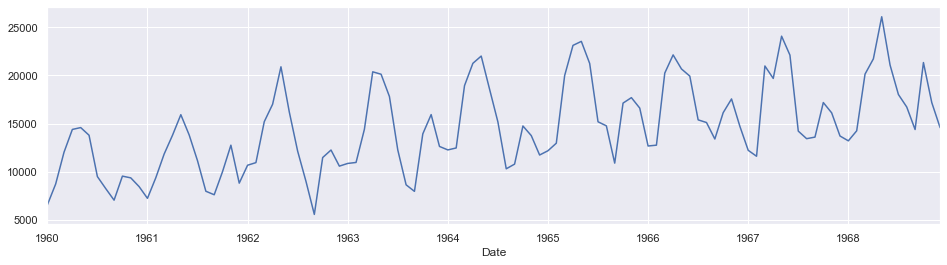

In [16]:
df1['Sales'].plot(figsize=(16,4))

<AxesSubplot:xlabel='Month', ylabel='Sales'>

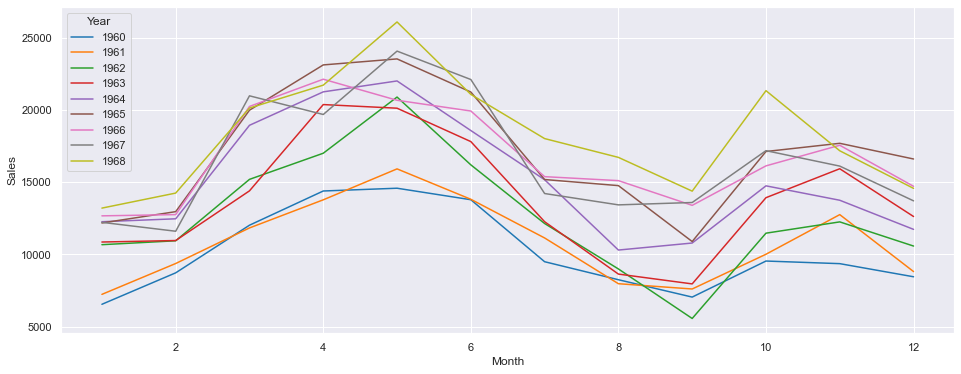

In [17]:
plt.figure(figsize=(16,6))

sns.lineplot(data=df1, x='Month',y='Sales', hue='Year', palette='tab10')

From year to year we see a repeating pattern.

<AxesSubplot:xlabel='Year', ylabel='Sales'>

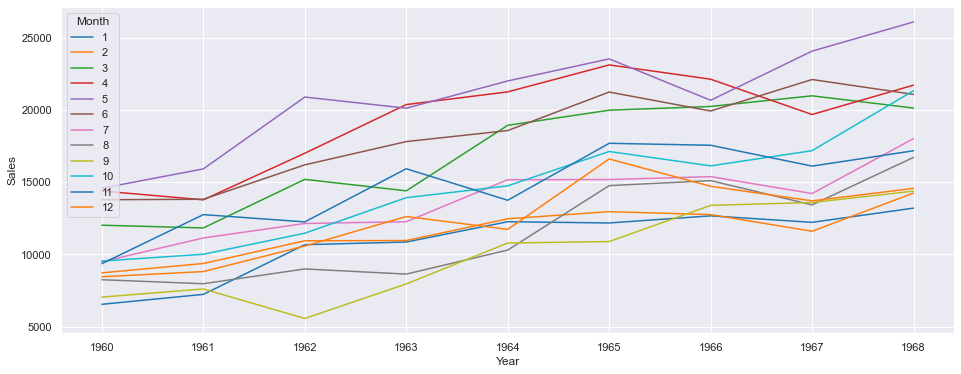

In [18]:
plt.figure(figsize=(16,6))

sns.lineplot(data=df1, x='Year',y='Sales', hue='Month', palette='tab10')

We are seeing a slight uptrend.

## linear regression

### features 1

Let's train regression on a set of features **Lags**

In [19]:
features

['i-12',
 'i-13',
 'i-14',
 'i-15',
 'i-16',
 'i-17',
 'i-18',
 'i-19',
 'i-20',
 'i-21',
 'i-22',
 'i-23',
 'i-24']

In [20]:
mod = LinearRegression()

In [21]:
df1 = df1.dropna(subset=features)

R2score = 0.65, MAE = 1648.15



(0.6545906087179552, 1648.1530569508698)

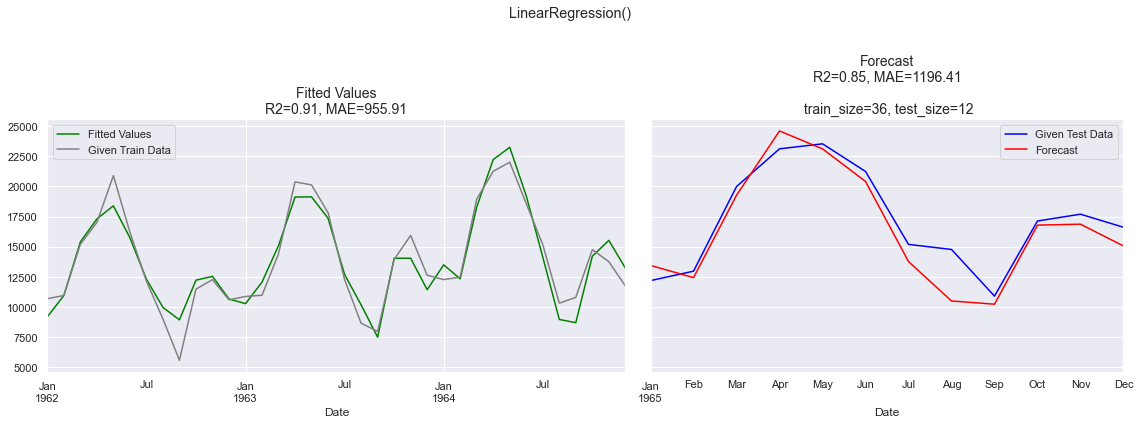

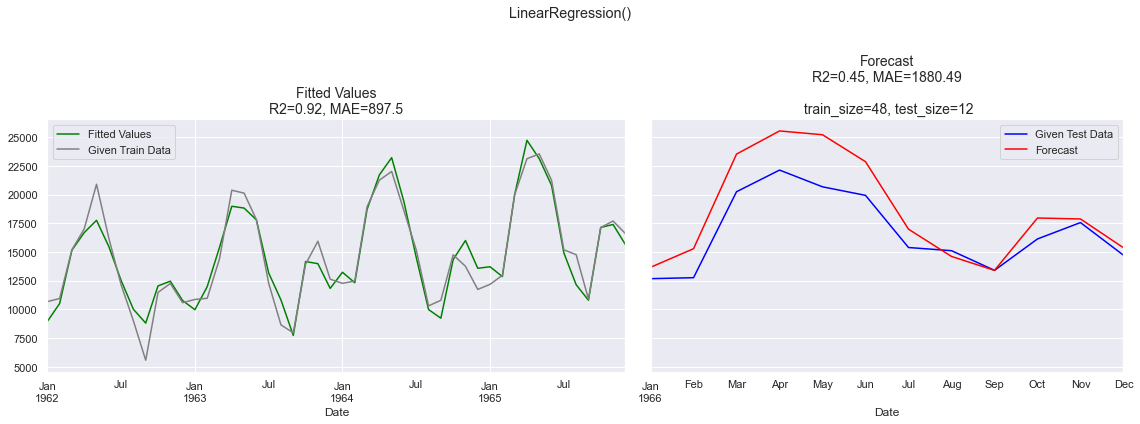

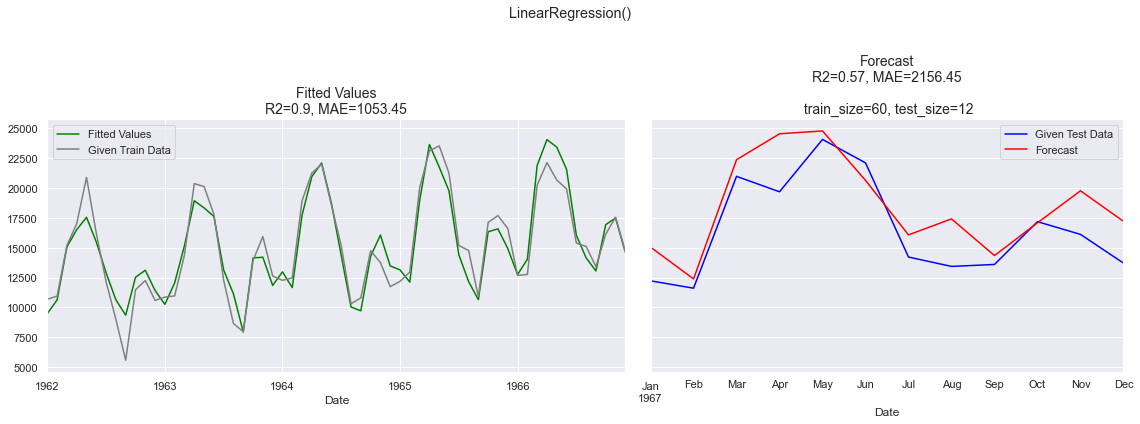

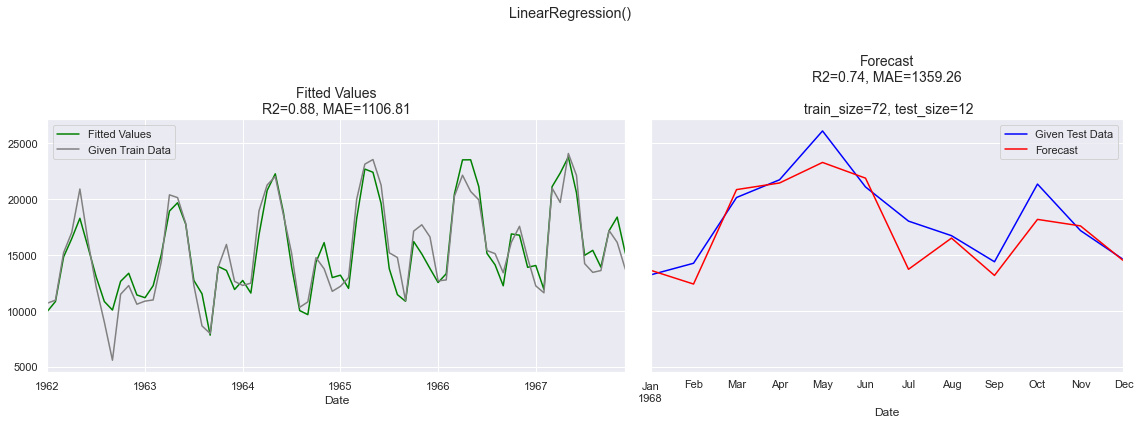

In [22]:
cross_validation(df1, mod, features,n_splits=4, target='Sales')

### features 2

Let's add to train more features of the month, season and day of the week.

In [23]:
features2 = features+['Month','dayofweek','Season']

R2score = 0.66, MAE = 1674.24



(0.6584905133228443, 1674.238968189307)

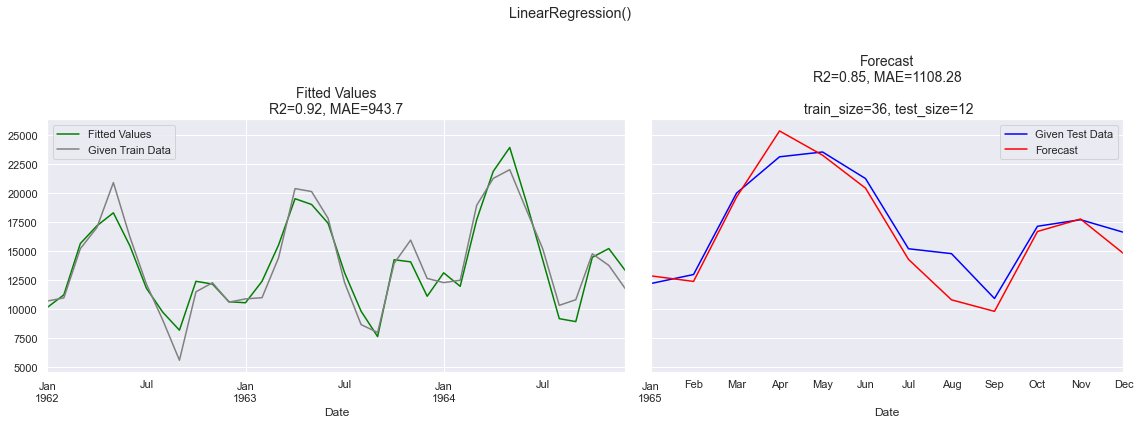

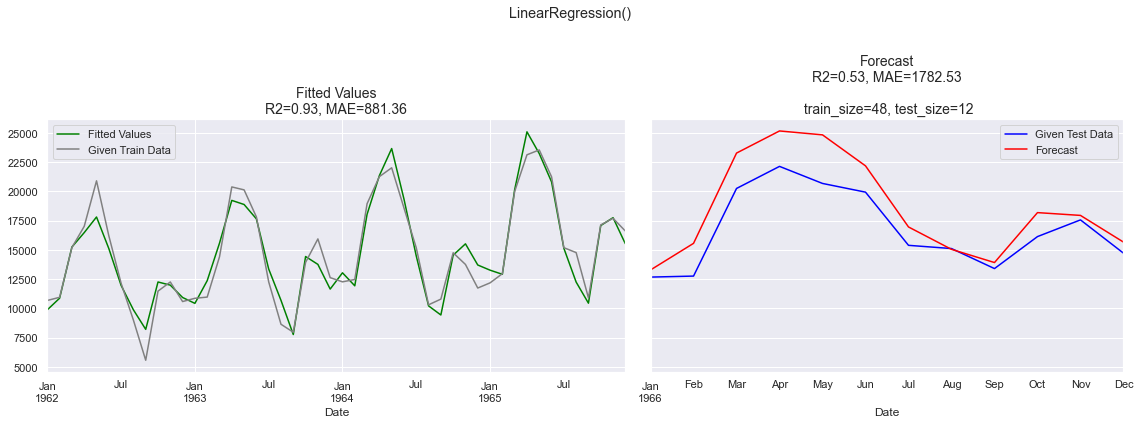

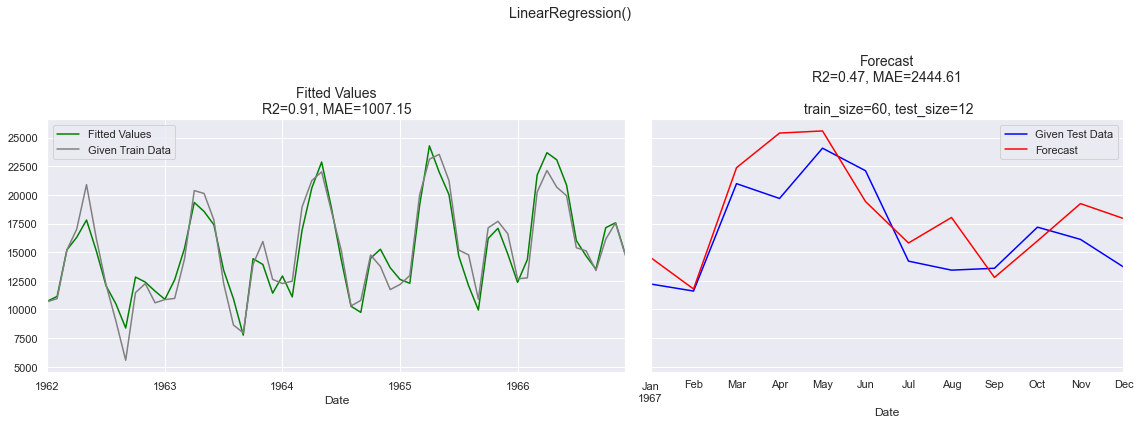

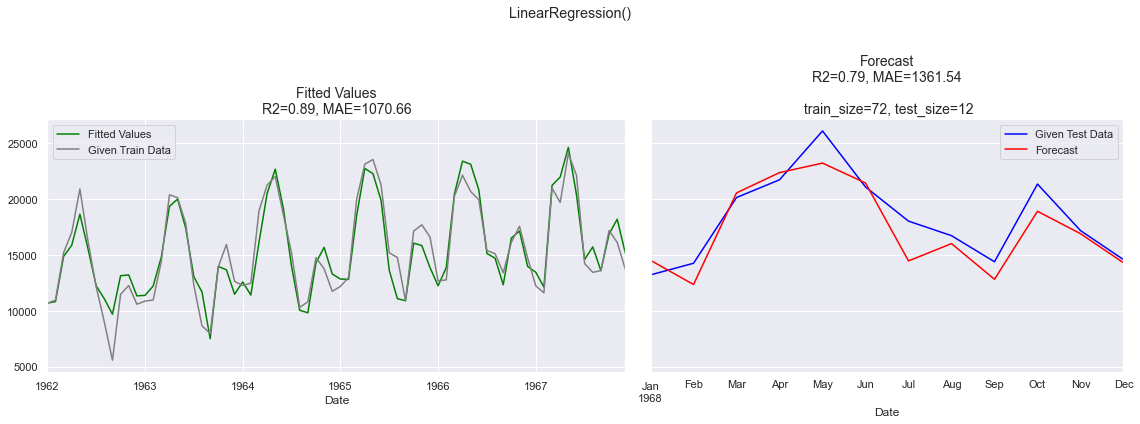

In [24]:
cross_validation(df1, mod, features2, n_splits=4, target='Sales')

### features 3

Let's add a little more.

In [25]:
features3 =features2+['Month_roll']

R2score = 0.61, MAE = 1849.90



(0.6096653519513585, 1849.8983844596657)

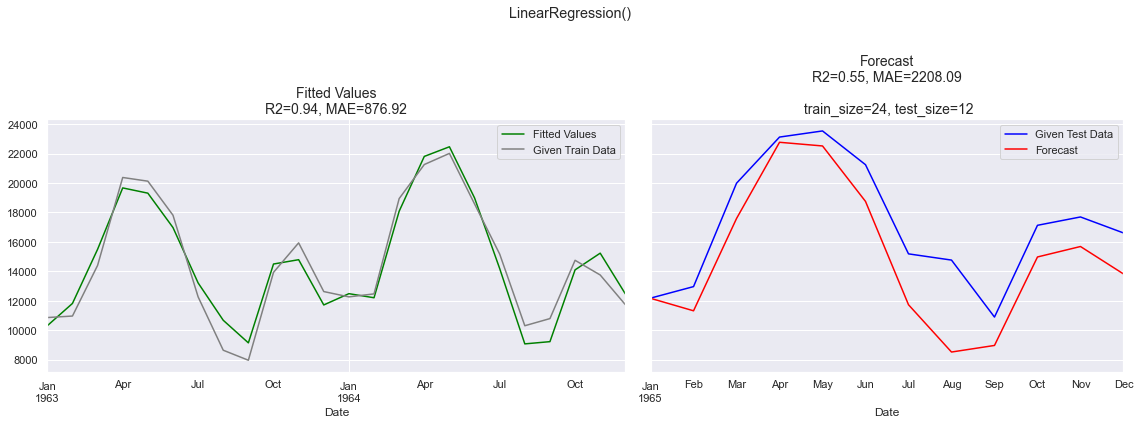

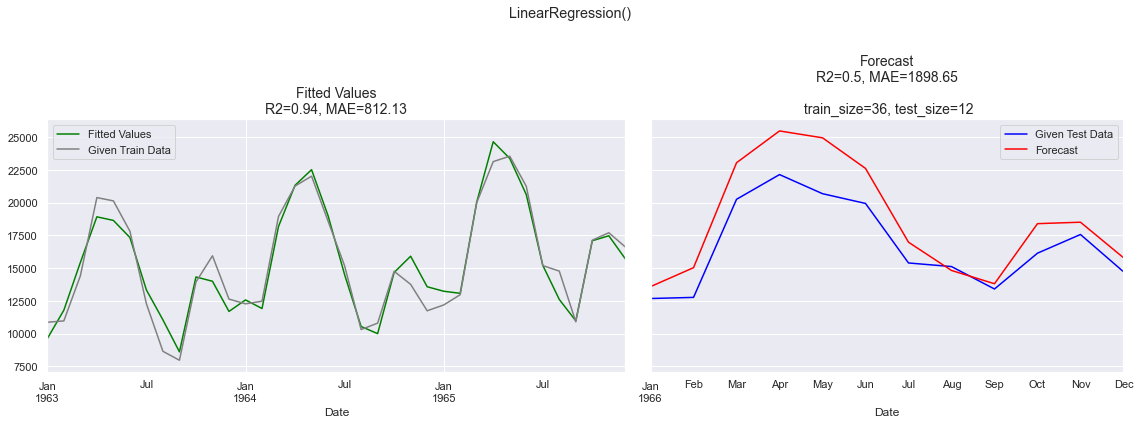

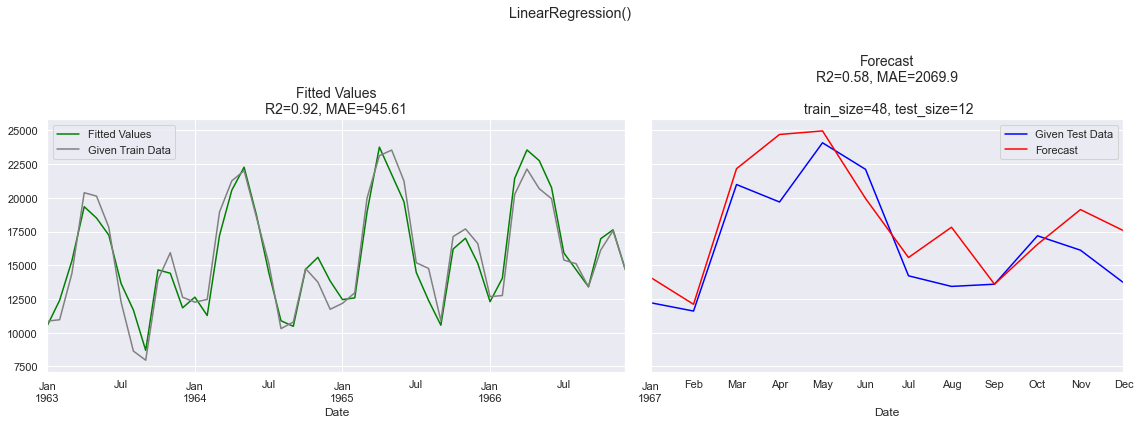

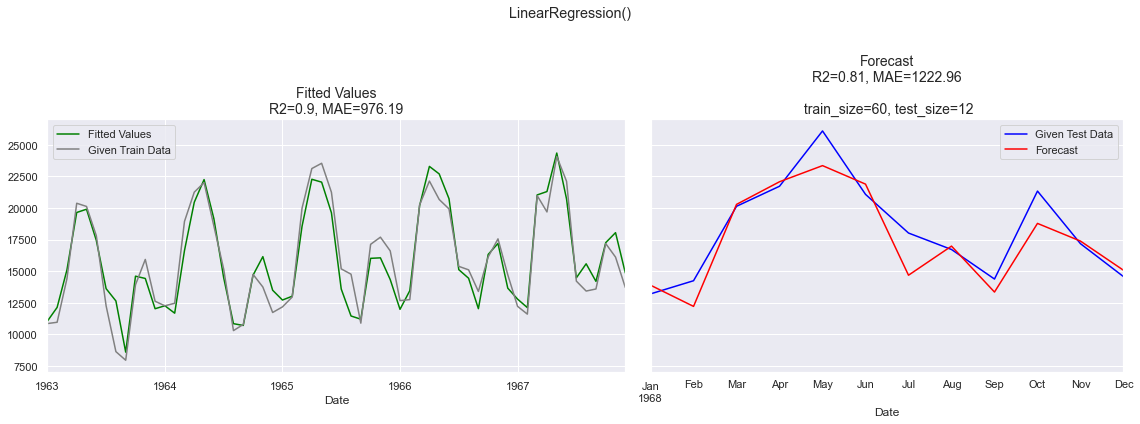

In [26]:
cross_validation(df1.dropna(), mod, features3, n_splits=4, target='Sales')

Linear regression shows good results, can be used as a baseline.

### linear regression per month

Consider each month separately and create a linear regression for each month, i.e. we make a prediction for 12 points separately.

R2 = 0.68, MAE = 1741.17


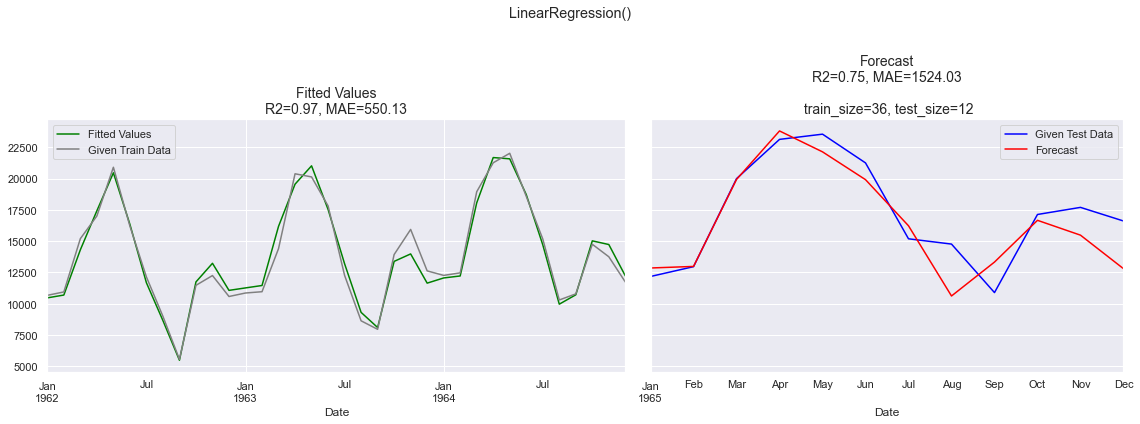

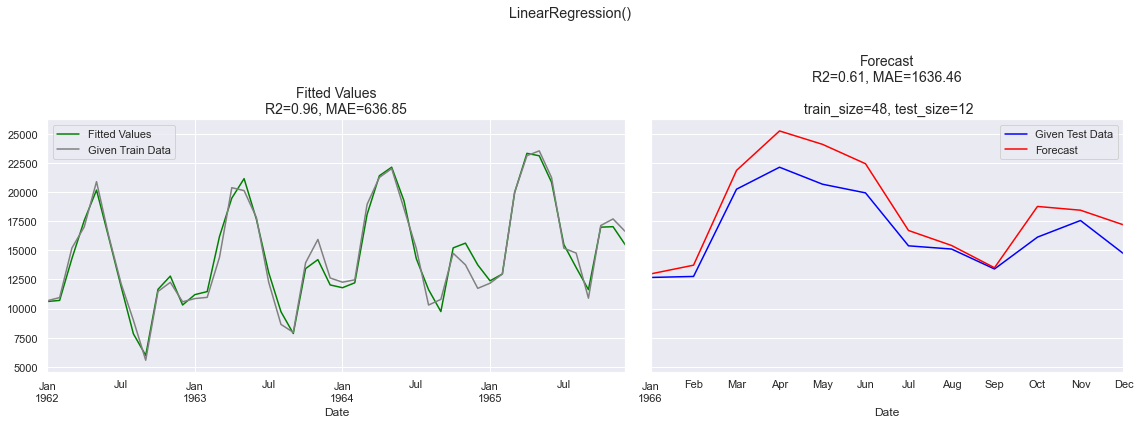

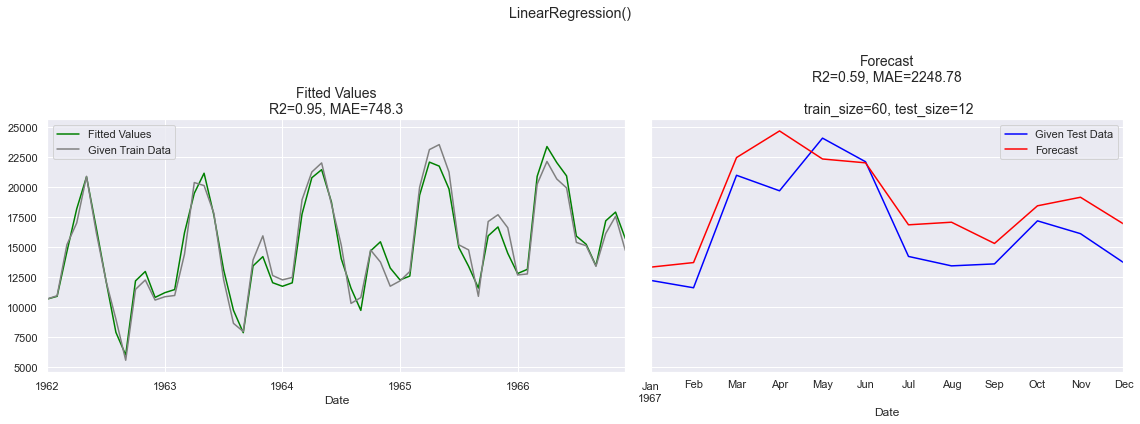

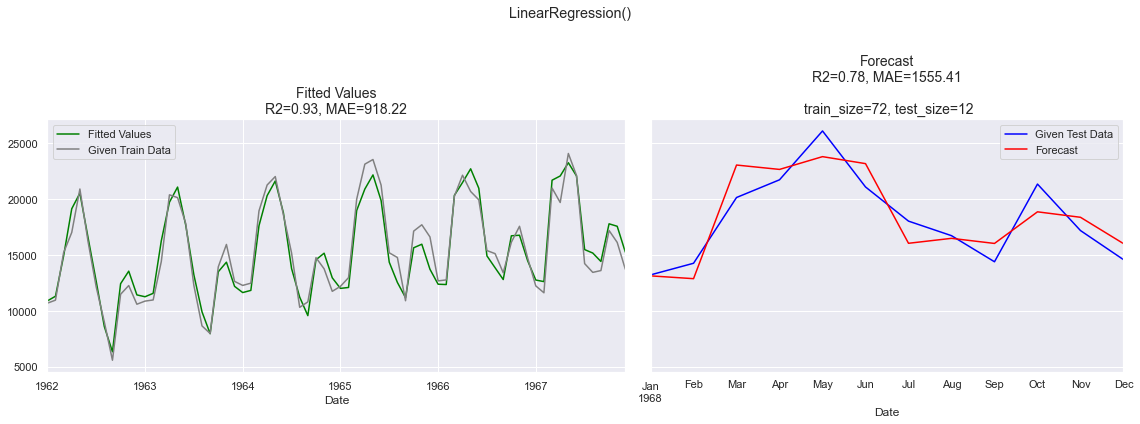

In [27]:
n_splits = 4
test_size = 12
r2_list, mae_list = [],[]
size = len(df1)

for i in range(n_splits,0,-1):
    idx = size - (i)*test_size
    train = df1[0:idx].copy()
    test = df1[idx:idx+test_size].copy()

    #train, test = df1[:-12].copy(), df1[-12:].copy()
    train['fittedvalues'] = 0
    test['predictions'] = 0

    mod = LinearRegression()

    for m in range(1,13):
        train_month = train.loc[train['Month']==m]
        test_month = test.loc[test['Month']==m]

        mod.fit(train_month[['Year']], train_month['Sales'])
        fittedvalues = mod.predict(train_month[['Year']])
        predictions = mod.predict(test_month[['Year']])

        train.loc[train['Month']==m,'fittedvalues'] = fittedvalues
        test.loc[test['Month']==m,'predictions'] = predictions
        
    r2_list.append(r2_score(test['Sales'], test['predictions']))
    mae_list.append(mean_absolute_error(test['Sales'],  test['predictions']))  
    
    plot_results(train['Sales'], test['Sales'], train['fittedvalues'], test['predictions'],title=str(mod))
print(f'R2 = {np.mean(r2_list):.2f}, MAE = {np.mean(mae_list):.2F}')

### features 4 

Let's try to train the model on the values for the last year and the average value of Sales for the month.

In [28]:
mod = LinearRegression()

R2score = 0.64, MAE = 1783.56



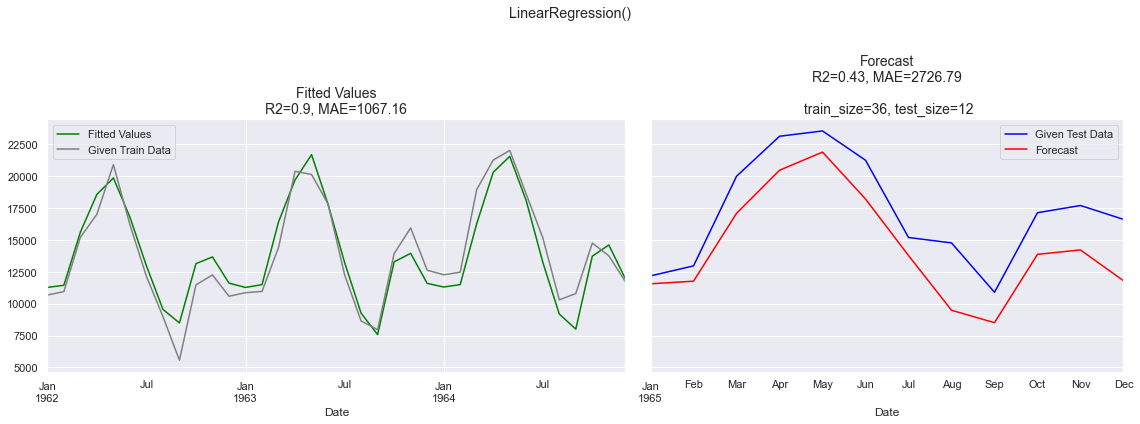

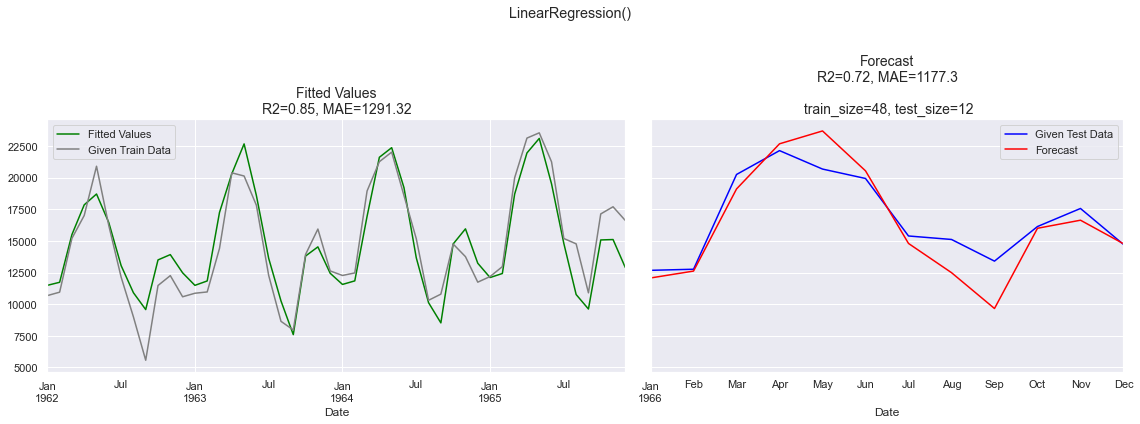

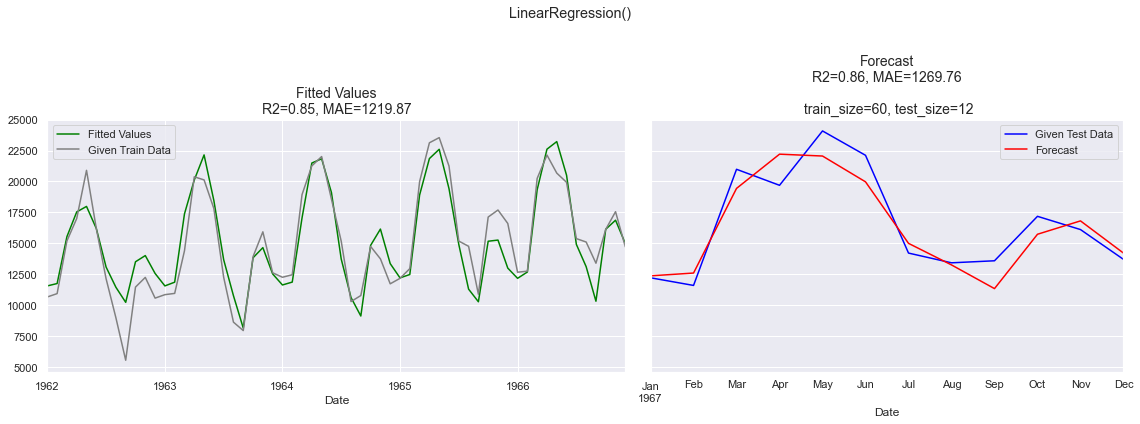

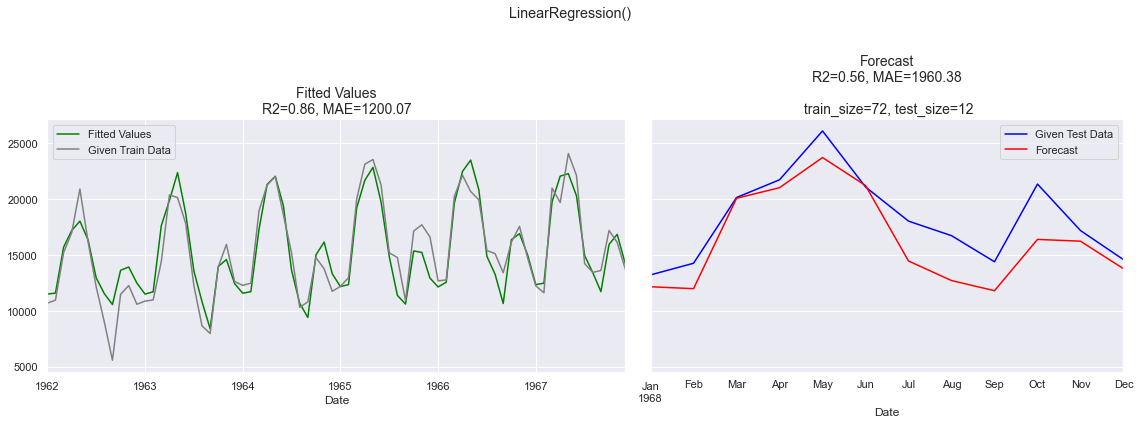

In [29]:
n_splits = 4
test_size = 12
r2_list, mae_list = [],[]
size = len(df1)

df1['Year_shift'] = df1['Sales'].shift(12)

for i in range(n_splits,0,-1):
    idx = size - (i)*test_size
    train = df1[0:idx].copy()
    test = df1[idx:idx+test_size].copy()
    
    month_mean = train.groupby('Month')['Sales'].mean()
    train['Month_mean'] = train['Month'].map(month_mean)
    test['Month_mean'] = test['Month'].map(month_mean)
    
    features4 = ['Month_mean', 'Year_shift']
    fittedvalues = mod.fit(train[features4].fillna(method='bfill'), train['Sales']).predict(train[features4].fillna(method='bfill'))
    predictions = mod.predict(test[features4])

    train = train.assign(fittedvalues = fittedvalues)
    test = test.assign(predictions = predictions)

    plot_results(train['Sales'], test['Sales'], train['fittedvalues'], test['predictions'],title=str(mod))

    r2_list.append(r2_score(test['Sales'], predictions))
    mae_list.append(mean_absolute_error(test['Sales'], predictions))

print(f'R2score = {np.mean(r2_list):.2f}, MAE = {np.mean(mae_list):.2f}\n')

<mark>The model shows the best result simply on **lags**.</mark>

## RandomForestRegressor

Using the same set of features, let's try to make a prediction with RandomForestRegressor.

### features 1

In [30]:
mod =RandomForestRegressor()

R2score = 0.65, MAE = 1706.68



(0.6547994050498865, 1706.6822916666667)

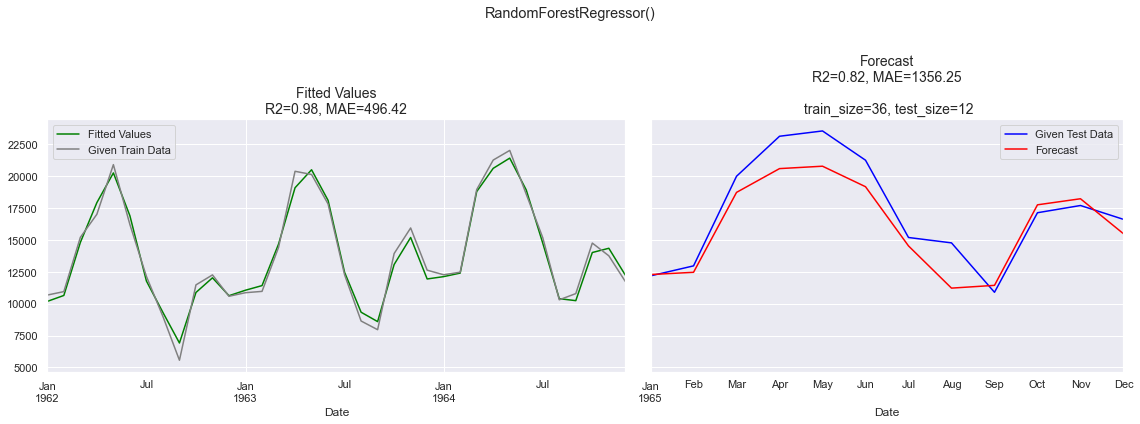

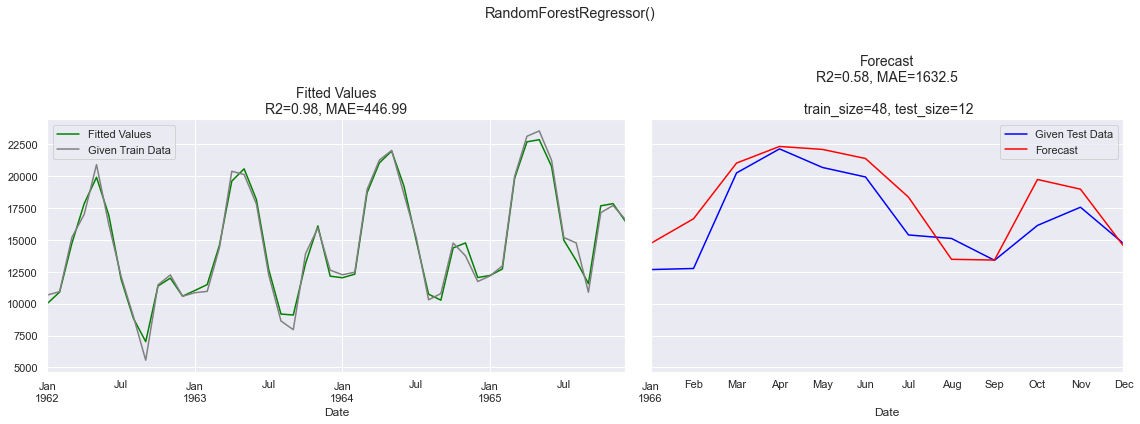

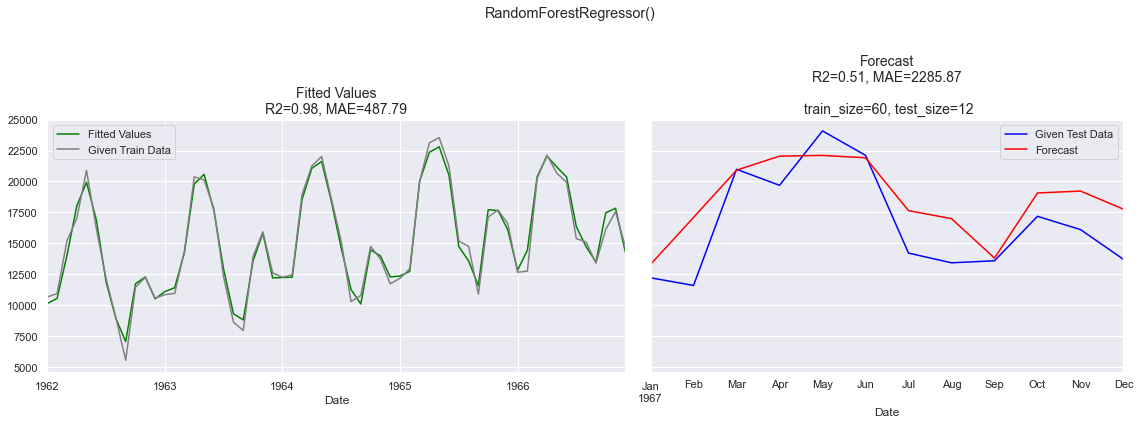

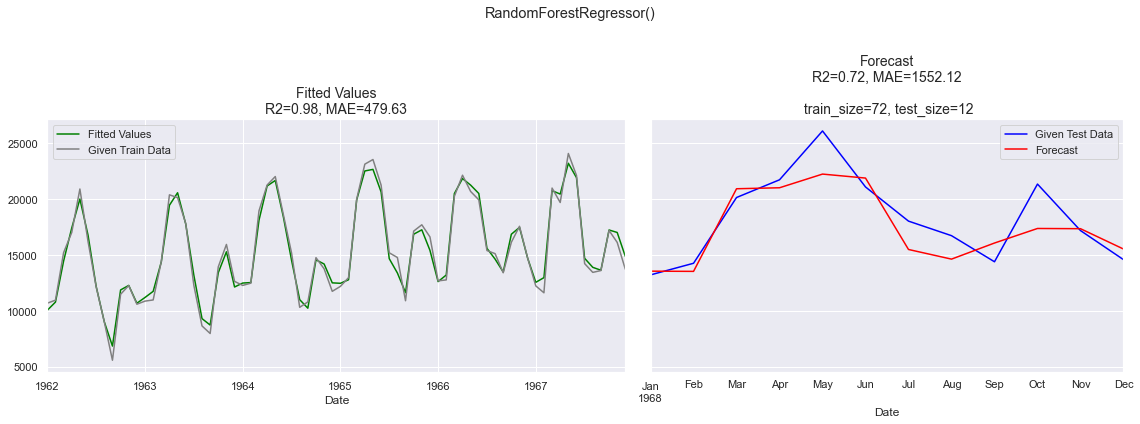

In [31]:
cross_validation(df1, mod, features,n_splits=4, target='Sales')

### features 2

R2score = 0.66, MAE = 1678.22



(0.6599786633965133, 1678.2158333333334)

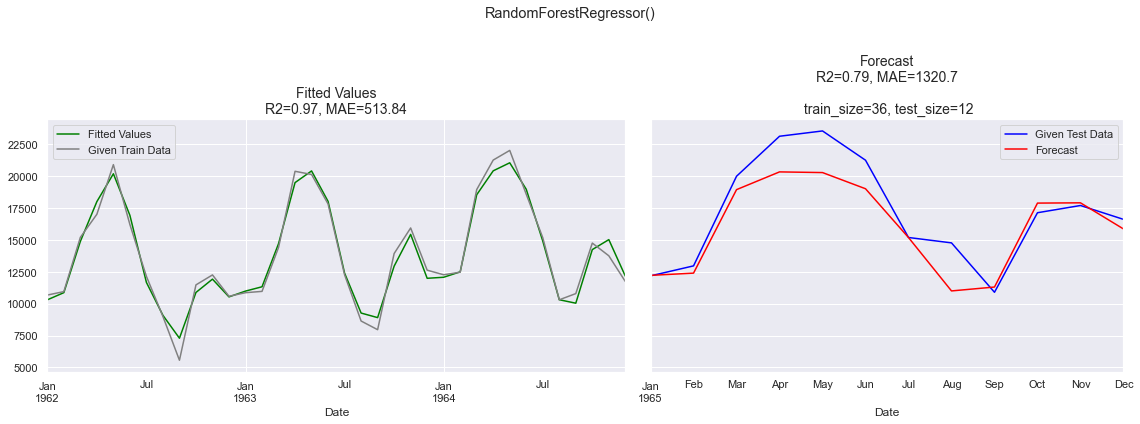

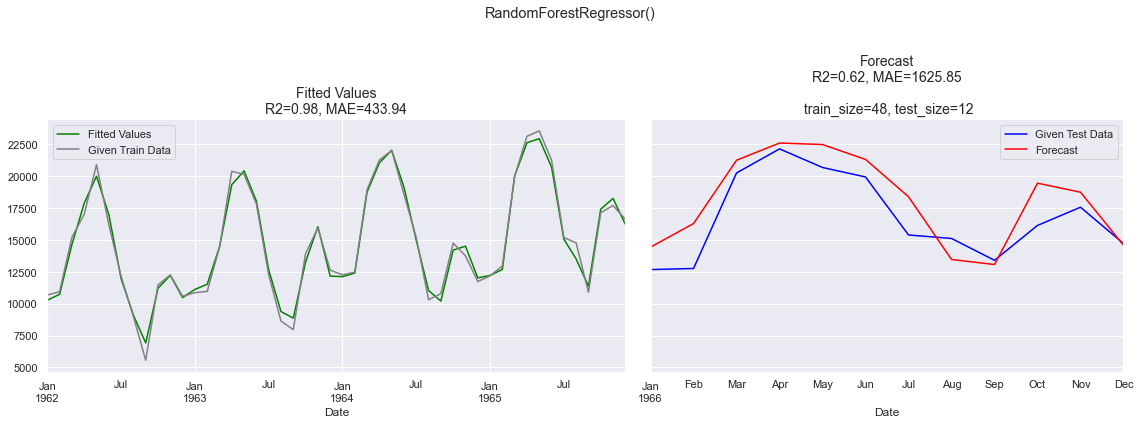

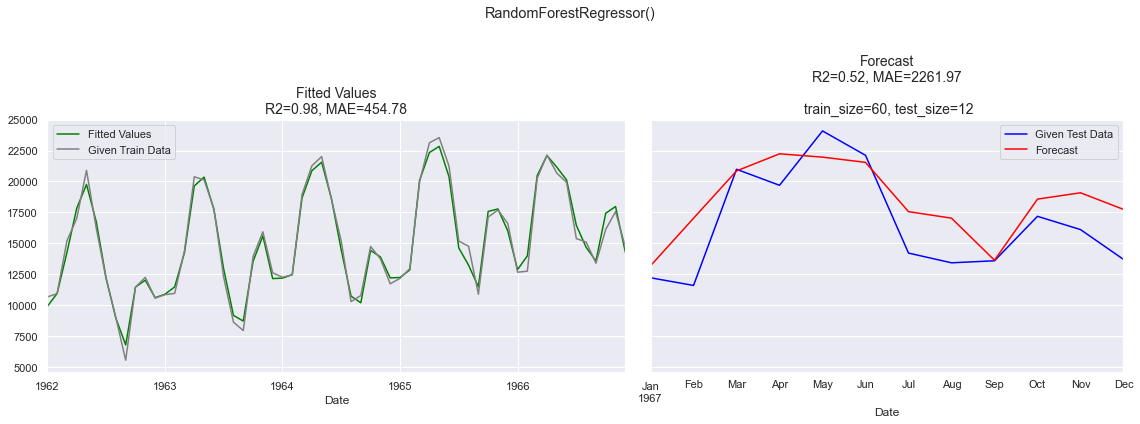

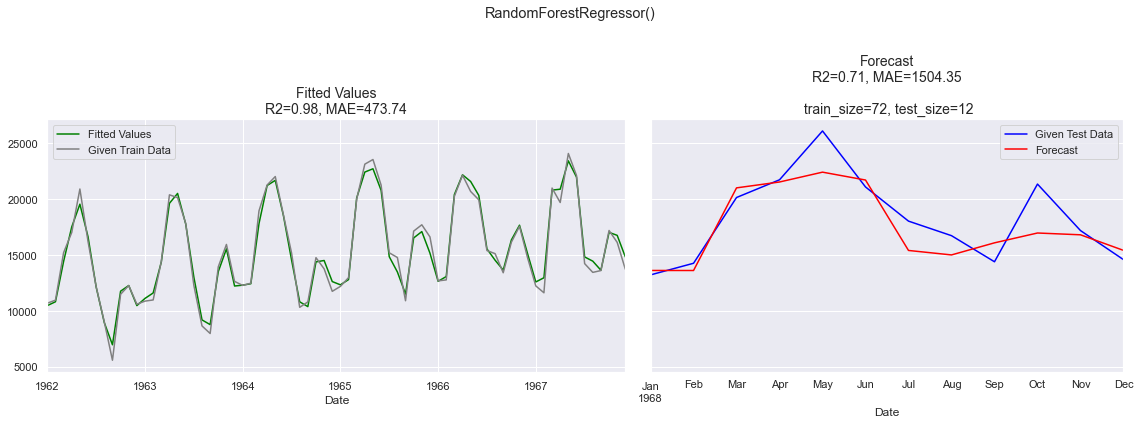

In [32]:
cross_validation(df1, mod, features2,n_splits=4, target='Sales')

### features 3

R2score = 0.72, MAE = 1576.68



(0.716485803356738, 1576.6787499999998)

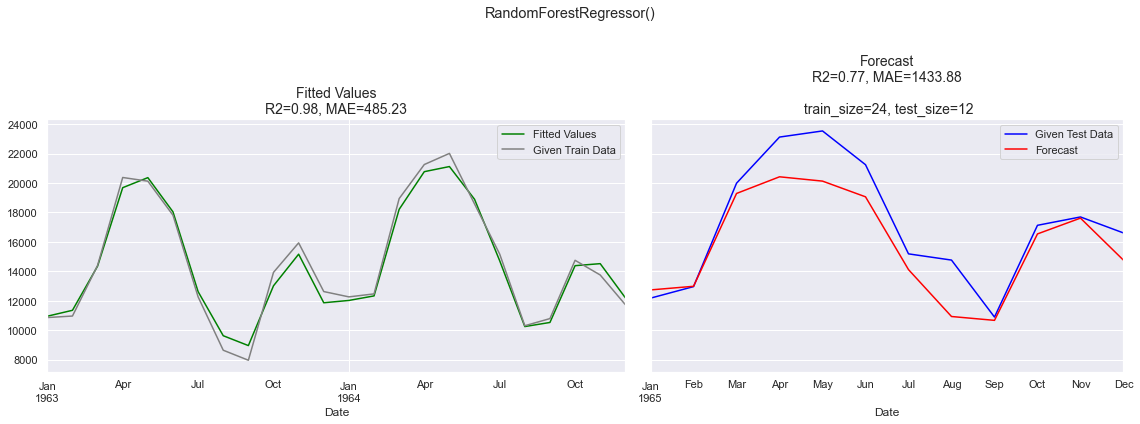

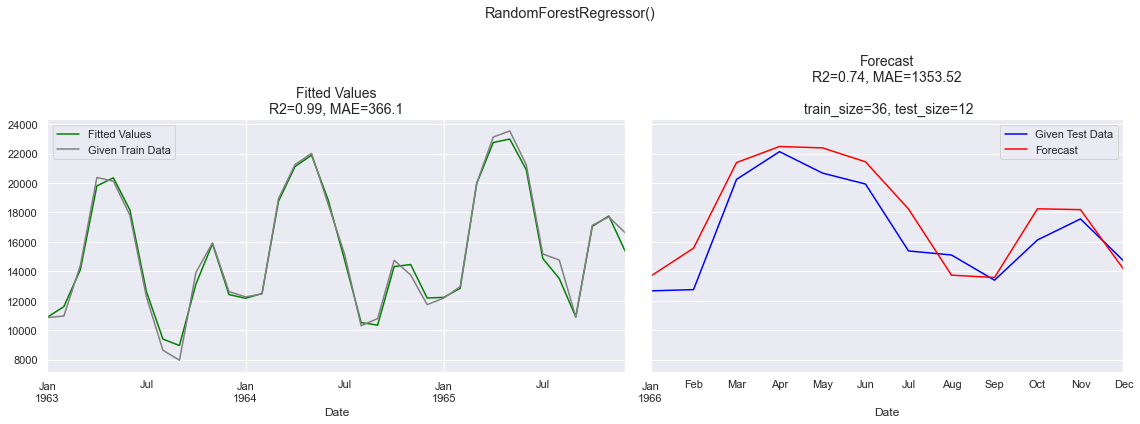

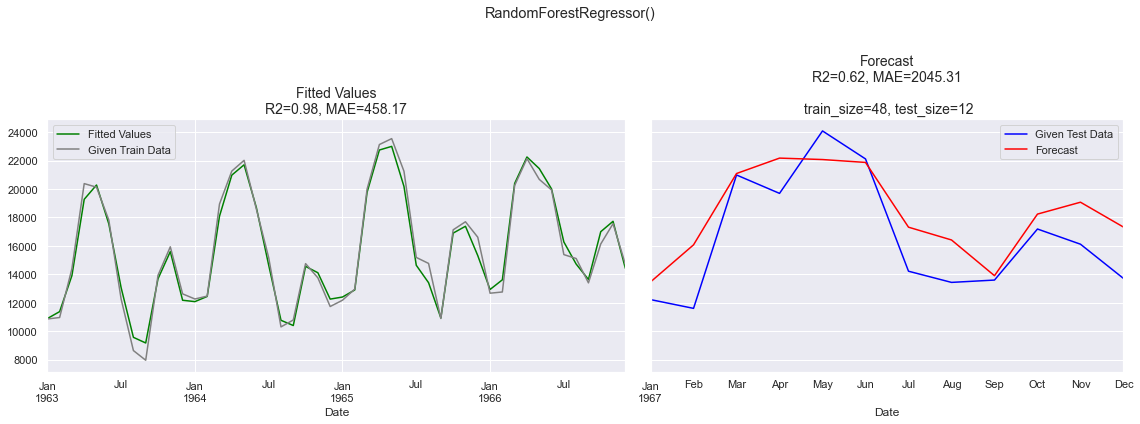

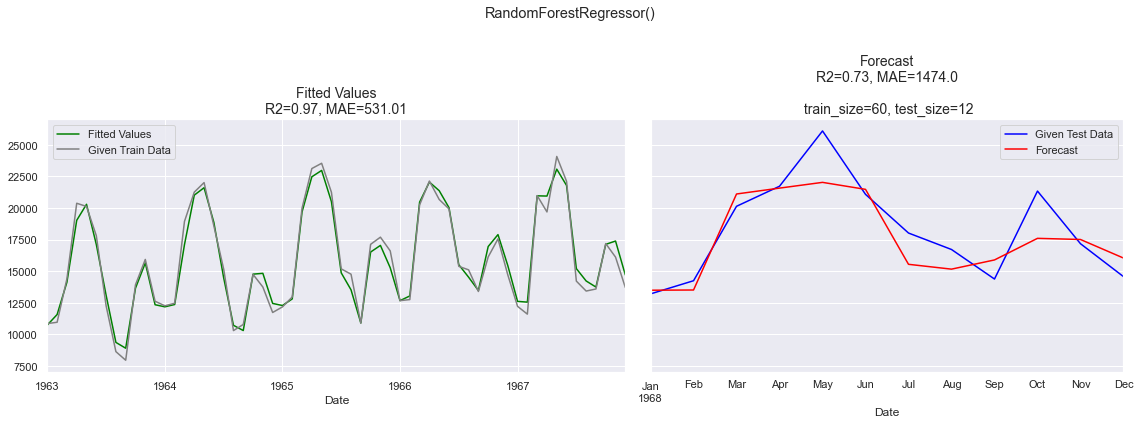

In [33]:
cross_validation(df1.dropna(), mod, features3,n_splits=4, target='Sales')

<mark>This model shows the best results of all</mark> Features are used:
   
     
     lags 12-24, 
    'Month',
    'dayofweek',
    'Season',
    'Month_roll'

# Time Series #2

**Columns**

    - Period - date
    - Revenue - target
    - Sales_quantity - number of goods sold. You can use it as a feature, but not at the current moment, 
      since we don't know how many products will be sold at the moment of forecasting
    - Average_cost - average price of the goods (Revenue / Sales_quantity)

In [81]:
df2 = pd.read_csv("month_value.csv")

In [82]:
df2.head()

Period       Revenue  Sales_quantity  Average_cost
0  01.01.2015 16,010,072.12       12,729.00      1,257.76
1  01.02.2015 15,807,587.45       11,636.00      1,358.51
2  01.03.2015 22,047,146.02       15,922.00      1,384.70
3  01.04.2015 18,814,583.29       15,227.00      1,235.61
4  01.05.2015 14,021,479.61        8,620.00      1,626.62

In [83]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Period          64 non-null     object 
 1   Revenue         64 non-null     float64
 2   Sales_quantity  64 non-null     float64
 3   Average_cost    64 non-null     float64
dtypes: float64(3), object(1)
memory usage: 2.1+ KB


In [84]:
df2['Period'] = pd.to_datetime(df2['Period'], dayfirst=True)
df2.set_index('Period', inplace=True)

''

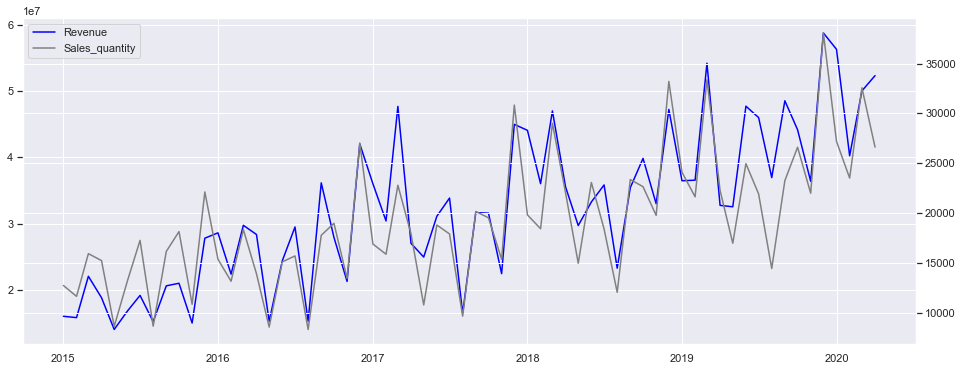

In [85]:
fig, ax1 = plt.subplots(1, figsize=(16,6))

ax2 = ax1.twinx()

p1, = ax1.plot(df2['Revenue'], label='Revenue', color= 'blue')
p2, = ax2.plot(df2['Sales_quantity'], label='Sales_quantity', color='grey')
lgns = [p1,p2]
ax1.legend(handles=lgns, loc='best')
;

<AxesSubplot:xlabel='Period'>

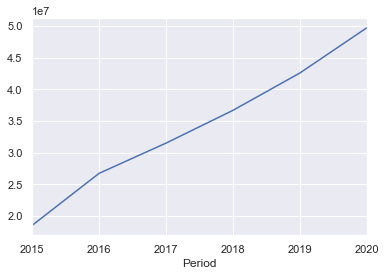

In [86]:
df2['Revenue'].resample('Y').mean().plot()

In [87]:
df2[['Revenue','Sales_quantity','Average_cost']].corr()

Revenue  Sales_quantity  Average_cost
Revenue            1.00            0.89          0.36
Sales_quantity     0.89            1.00         -0.09
Average_cost       0.36           -0.09          1.00

## Task 


Using the previous methods, as well as adding more features from dataset, also build a forecast for 3 months and a year ahead

## Add features

### Time related features

In [88]:
# month, dayofweek, season

months = list(range(1,13))
#season = ['winter','winter','spring','spring','spring', 'sommer','sommer','sommer','fall','fall','fall', 'winter']
season = [1,1,2,2,2,3,3,3,4,4,4,1]
dict_map = {m:s for m,s in zip(months,season)}

In [89]:
df2['Month'] = df2.index.month
df2['Year'] = df2.index.year
df2['Season'] = df2['Month'].map(dict_map)

In [90]:
#df2

<AxesSubplot:xlabel='Month', ylabel='Revenue'>

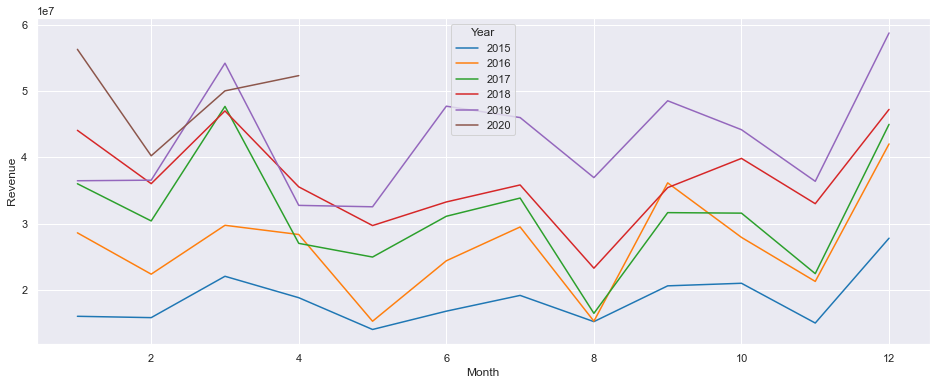

In [91]:
plt.figure(figsize=(16,6))

sns.lineplot(data=df2, x='Month',y='Revenue', hue='Year', palette='tab10')

<AxesSubplot:xlabel='Year', ylabel='Revenue'>

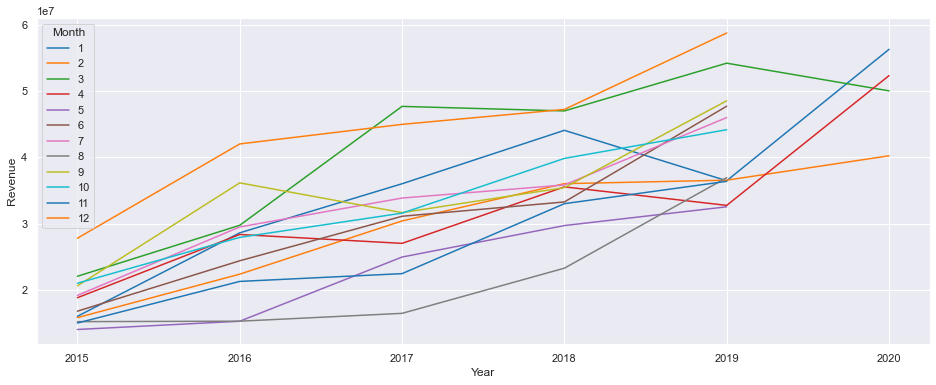

In [92]:
plt.figure(figsize=(16,6))

sns.lineplot(data=df2, x='Year',y='Revenue', hue='Month', palette='tab10')

### Rolling Avg Revenue, Sales_quantity, Average_cost per Month

If we group by month and count the rolling window with the setting **closed='left'**, then the future will not appear in our features, i.e. we will only use historical data.

In [93]:
df2['Revenue_Month_roll'] = df2.groupby('Month')['Revenue'].rolling(3, closed='left').mean().reset_index(0, drop=True)

In [94]:
df2['Sales_quantity_Month_roll'] = df2.groupby('Month')['Sales_quantity'].rolling(3, closed='left').mean().reset_index(0, drop=True)

In [95]:
df2['Average_cost_Month_roll'] = df2.groupby('Month')['Average_cost'].rolling(3, closed='left').mean().reset_index(0, drop=True)

let's calculate the average and make a shift so as not to capture months from the future

In [96]:
df2['Revenue_roll_4'] = df2['Revenue'].rolling(4).mean()
df2['Revenue_roll_4'] = df2['Revenue_roll_4'].shift(4)

df2['Sales_quantity_roll_4'] = df2['Sales_quantity'].rolling(4).mean()
df2['Sales_quantity_roll_4'] = df2['Sales_quantity_roll_4'].shift(4)

In [97]:
df2.tail()

Revenue  Sales_quantity  Average_cost  Month  Year  Season  \
Period                                                                        
2019-12-01 58,756,473.66       38,069.00      1,543.42     12  2019       1   
2020-01-01 56,288,300.87       27,184.00      2,070.64      1  2020       1   
2020-02-01 40,225,243.26       23,509.00      1,711.06      2  2020       1   
2020-03-01 50,022,165.23       32,569.00      1,535.88      3  2020       2   
2020-04-01 52,320,692.94       26,615.00      1,965.83      4  2020       2   

            Revenue_Month_roll  Sales_quantity_Month_roll  \
Period                                                      
2019-12-01       44,734,037.95                  30,356.33   
2020-01-01       38,844,953.87                  20,265.67   
2020-02-01       34,321,187.07                  18,637.33   
2020-03-01       49,624,275.95                  28,389.67   
2020-04-01       31,764,814.01                  20,736.00   

            Average_cost_Month_roll  Revenue_roll_4  Sales_quantity_roll_4  
Period                                                                      
2019-12-01                 1,478.28   40,791,791.44              19,568.25  
2020-01-01                 1,956.47   44,790,442.09              21,139.75  
2020-02-01                 1,853.75   43,903,120.73              21,551.00  
2020-03-01                 1,778.83   41,498,824.46              21,568.50  
2020-04-01                 1,530.61   46,954,526.62              27,478.00

### Lags

In [98]:
features_lags = []

for i in range(3,13):    
    df2['i-'+str(i)] = df2['Revenue'].shift(i)
    features_lags.append('i-'+str(i))

In [99]:
df2[features_lags+['Revenue']].corr()['Revenue']

i-3       0.81
i-4       0.44
i-5       0.39
i-6       0.69
i-7       0.36
i-8       0.33
i-9       0.73
i-10      0.46
i-11      0.39
i-12      0.83
Revenue   1.00
Name: Revenue, dtype: float64

In [100]:
df2.tail()

Revenue  Sales_quantity  Average_cost  Month  Year  Season  \
Period                                                                        
2019-12-01 58,756,473.66       38,069.00      1,543.42     12  2019       1   
2020-01-01 56,288,300.87       27,184.00      2,070.64      1  2020       1   
2020-02-01 40,225,243.26       23,509.00      1,711.06      2  2020       1   
2020-03-01 50,022,165.23       32,569.00      1,535.88      3  2020       2   
2020-04-01 52,320,692.94       26,615.00      1,965.83      4  2020       2   

            Revenue_Month_roll  Sales_quantity_Month_roll  \
Period                                                      
2019-12-01       44,734,037.95                  30,356.33   
2020-01-01       38,844,953.87                  20,265.67   
2020-02-01       34,321,187.07                  18,637.33   
2020-03-01       49,624,275.95                  28,389.67   
2020-04-01       31,764,814.01                  20,736.00   

            Average_cost_Month_roll  Revenue_roll_4  Sales_quantity_roll_4  \
Period                                                                       
2019-12-01                 1,478.28   40,791,791.44              19,568.25   
2020-01-01                 1,956.47   44,790,442.09              21,139.75   
2020-02-01                 1,853.75   43,903,120.73              21,551.00   
2020-03-01                 1,778.83   41,498,824.46              21,568.50   
2020-04-01                 1,530.61   46,954,526.62              27,478.00   

                     i-3           i-4           i-5           i-6  \
Period                                                               
2019-12-01 48,526,260.13 36,933,665.02 45,992,141.57 47,709,701.63   
2020-01-01 44,160,416.18 48,526,260.13 36,933,665.02 45,992,141.57   
2020-02-01 36,374,956.49 44,160,416.18 48,526,260.13 36,933,665.02   
2020-03-01 58,756,473.66 36,374,956.49 44,160,416.18 48,526,260.13   
2020-04-01 56,288,300.87 58,756,473.66 36,374,956.49 44,160,416.18   

                     i-7           i-8           i-9          i-10  \
Period                                                               
2019-12-01 32,531,657.54 32,743,989.61 54,198,706.72 36,546,498.66   
2020-01-01 47,709,701.63 32,531,657.54 32,743,989.61 54,198,706.72   
2020-02-01 45,992,141.57 47,709,701.63 32,531,657.54 32,743,989.61   
2020-03-01 36,933,665.02 45,992,141.57 47,709,701.63 32,531,657.54   
2020-04-01 48,526,260.13 36,933,665.02 45,992,141.57 47,709,701.63   

                    i-11          i-12  
Period                                  
2019-12-01 36,459,960.09 47,221,828.20  
2020-01-01 36,546,498.66 36,459,960.09  
2020-02-01 54,198,706.72 36,546,498.66  
2020-03-01 32,743,989.61 54,198,706.72  
2020-04-01 32,531,657.54 32,743,989.61

## LinearRegression

### Lags feautures

R2score = -0.53, MAE = 6712780.78



(-0.528010489778056, 6712780.78390262)

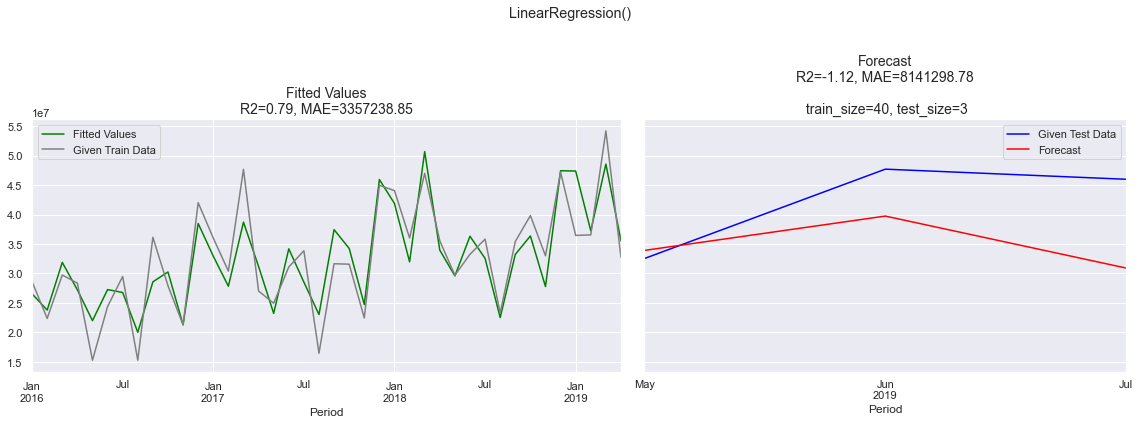

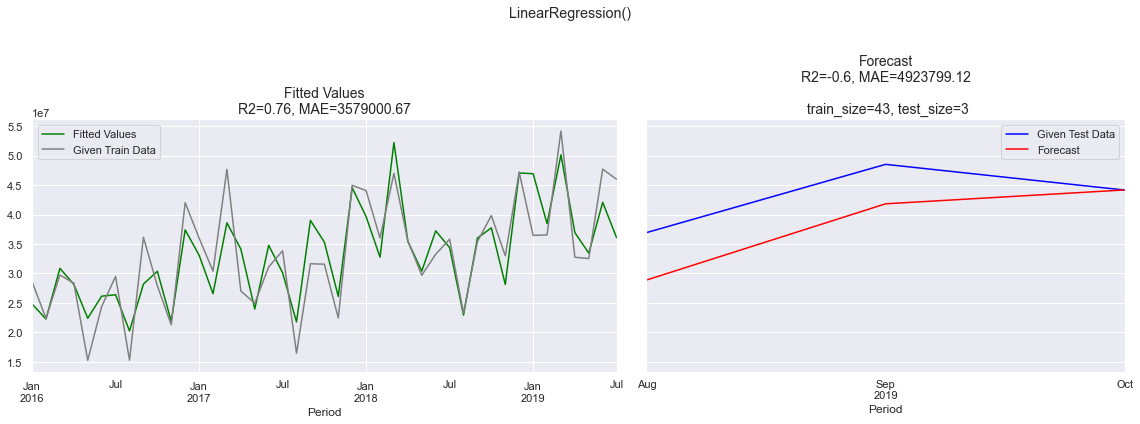

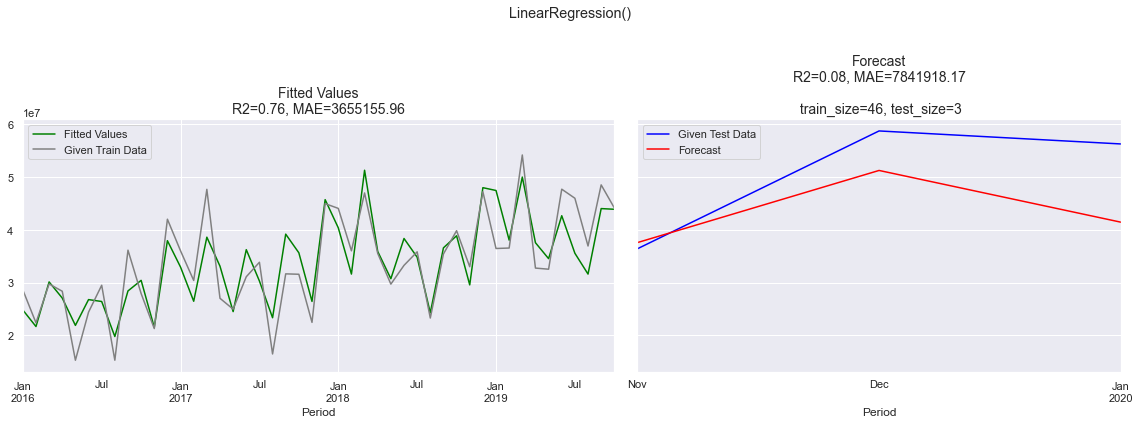

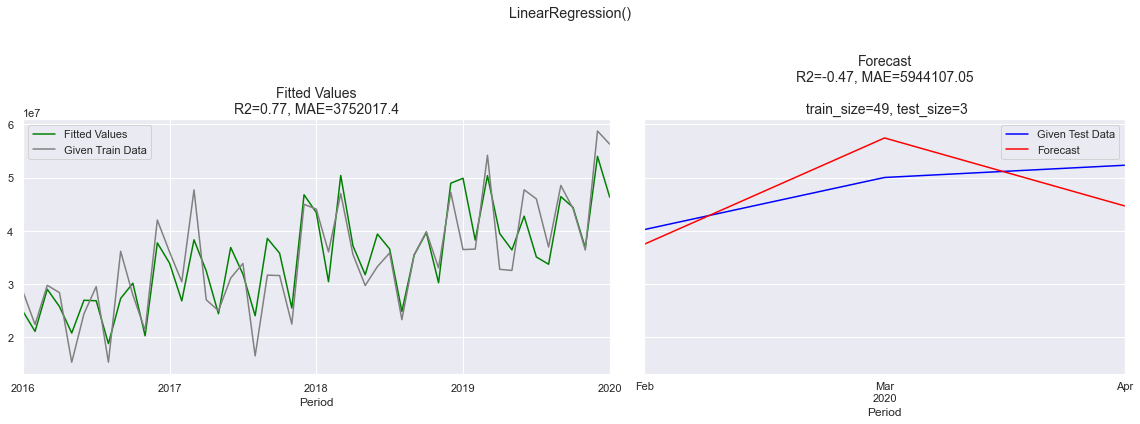

In [101]:
mod = LinearRegression()

cross_validation(df2.dropna(subset=features_lags), mod, features_lags,n_splits=4, target='Revenue', test_size=3)

The model only on lag values does not work very well. Let's try on all the features.

### Extra features

In [102]:
df2.columns

Index(['Revenue', 'Sales_quantity', 'Average_cost', 'Month', 'Year', 'Season',
       'Revenue_Month_roll', 'Sales_quantity_Month_roll',
       'Average_cost_Month_roll', 'Revenue_roll_4', 'Sales_quantity_roll_4',
       'i-3', 'i-4', 'i-5', 'i-6', 'i-7', 'i-8', 'i-9', 'i-10', 'i-11',
       'i-12'],
      dtype='object')

In [103]:
features = ['Month', 'Season',
       'Revenue_Month_roll', 'Sales_quantity_Month_roll',
       'Average_cost_Month_roll', 'Revenue_roll_4', 'Sales_quantity_roll_4'] + features_lags

R2score = -9.69, MAE = 17733321.85



(-9.687321442194685, 17733321.854832463)

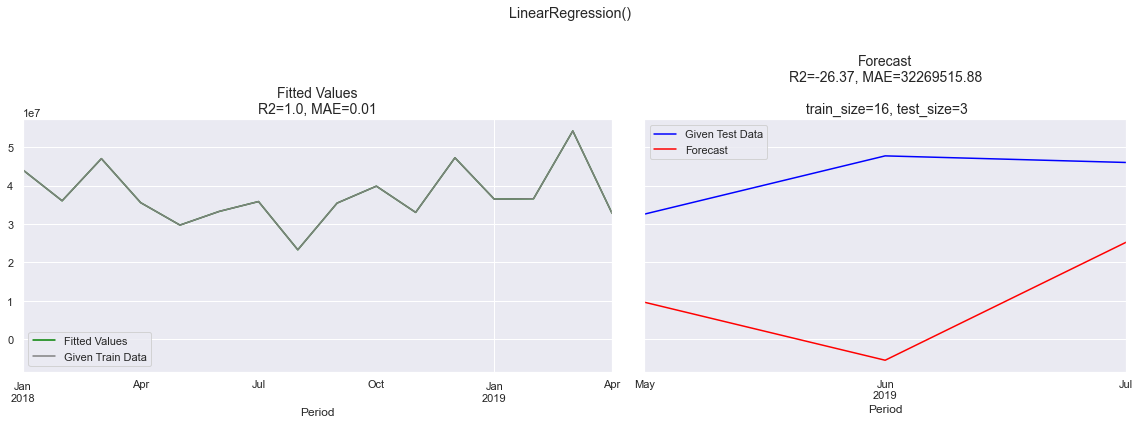

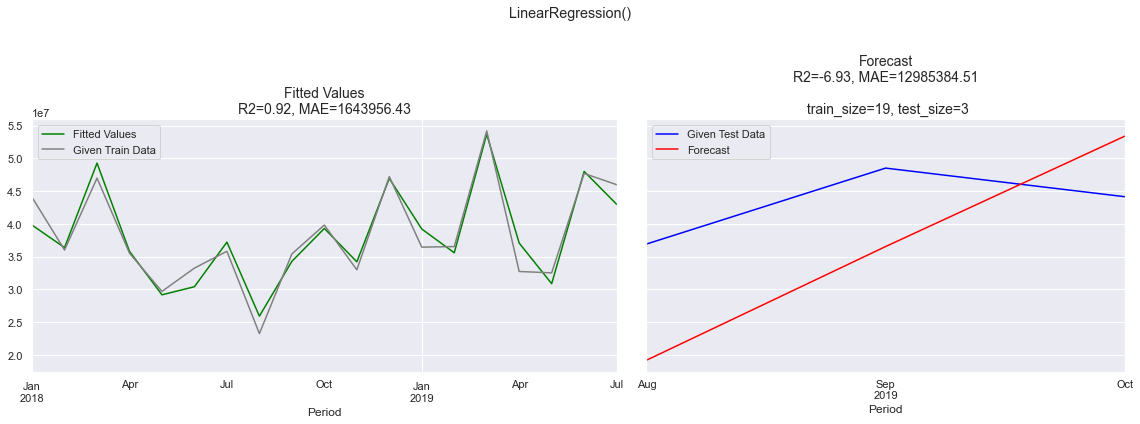

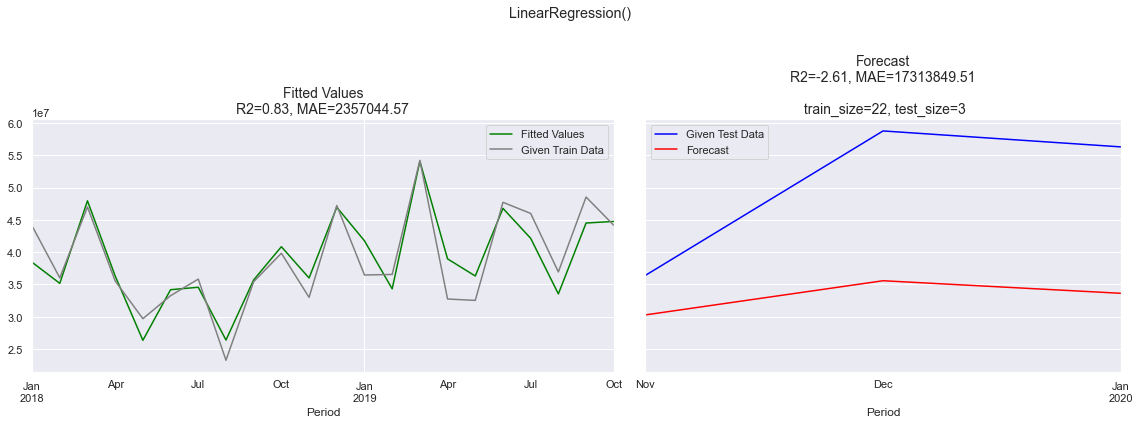

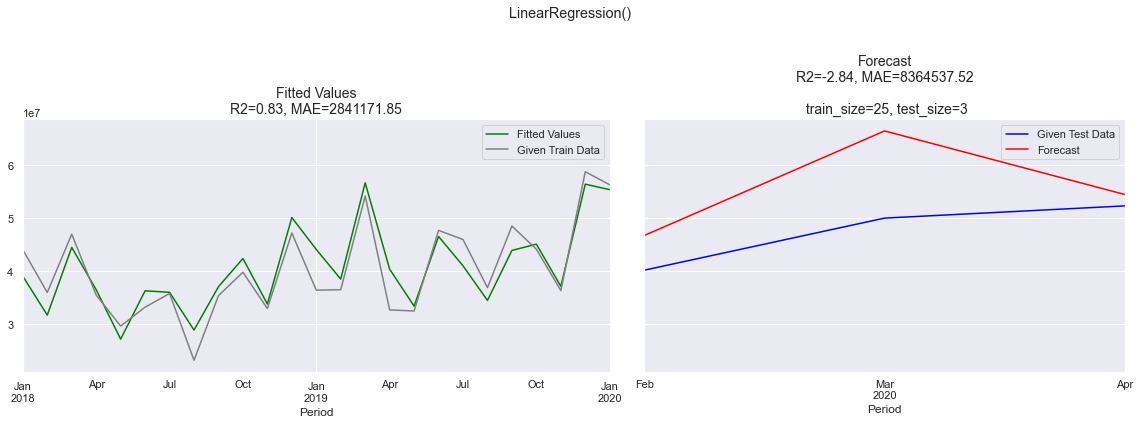

In [104]:
mod = LinearRegression()
cross_validation(df2.dropna(subset=features), mod, features,n_splits=4, target='Revenue', test_size=3)

Additional information clearly interferes with our model.

## RandomForestRegressor

R2score = -0.02, MAE = 5689591.33



(-0.017669485251815054, 5689591.331632907)

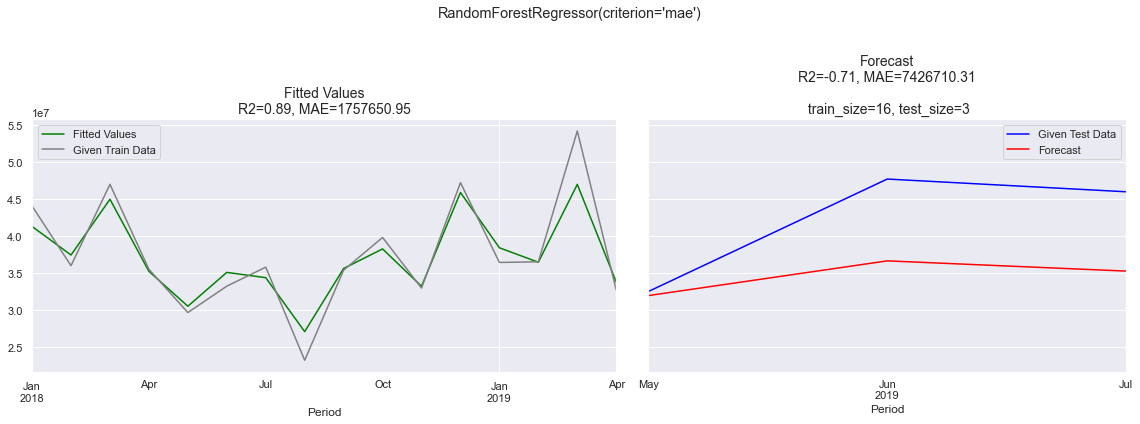

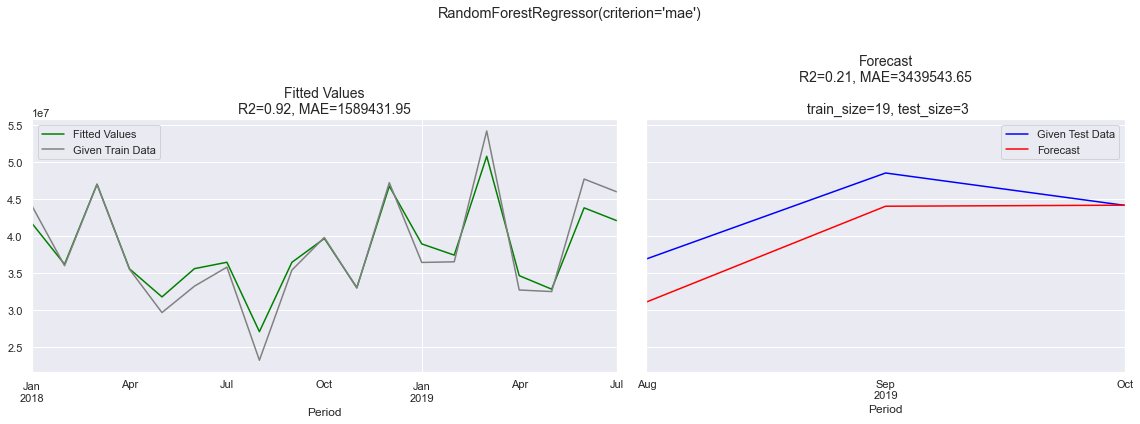

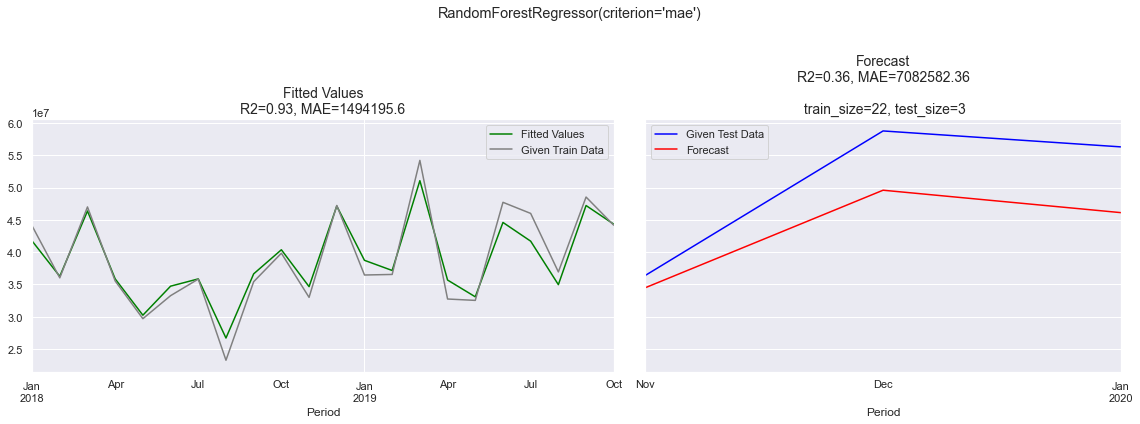

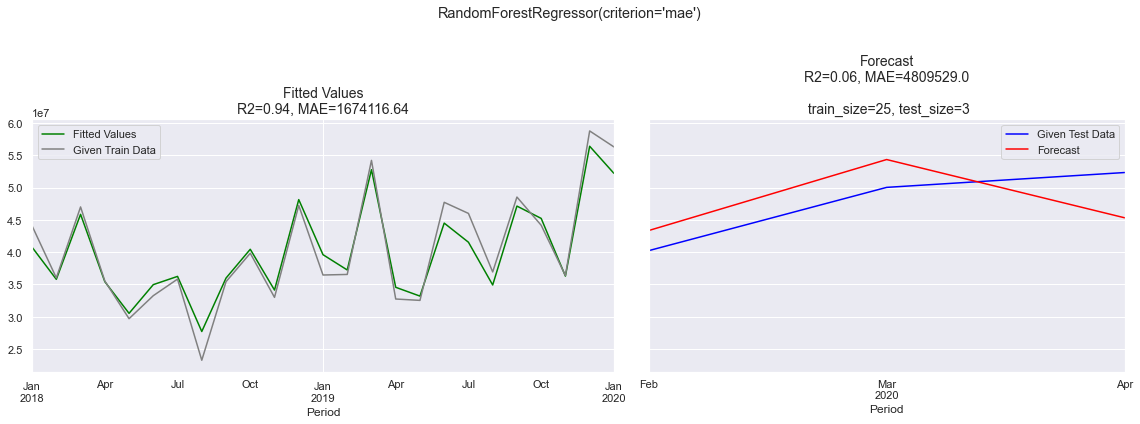

In [105]:
mod =RandomForestRegressor(criterion='mae')

cross_validation(df2.dropna(subset=features), mod, features,n_splits=4, target='Revenue', test_size=3)

RandomForestRegressor works better with the features, but far from ideal.

## XGBRegressor

R2score = -1.13, MAE = 7005768.26



(-1.1320198995416015, 7005768.260465)

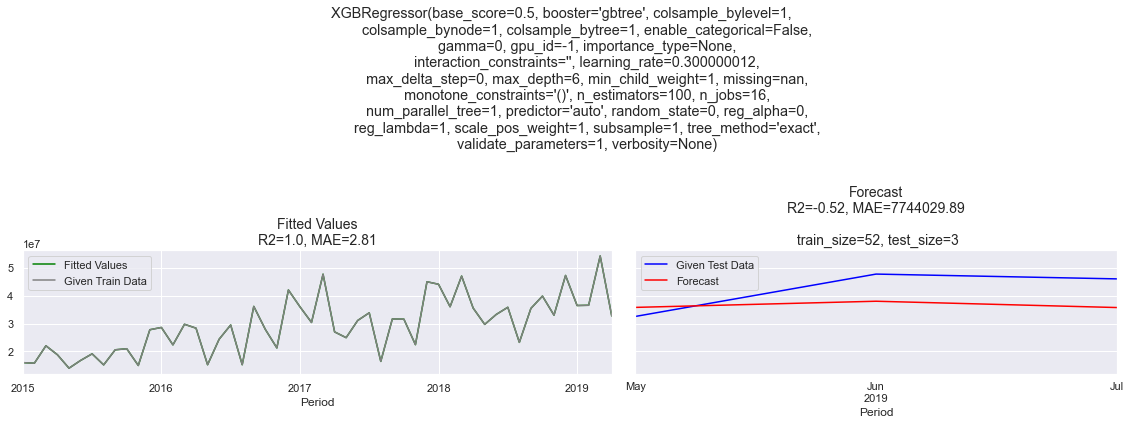

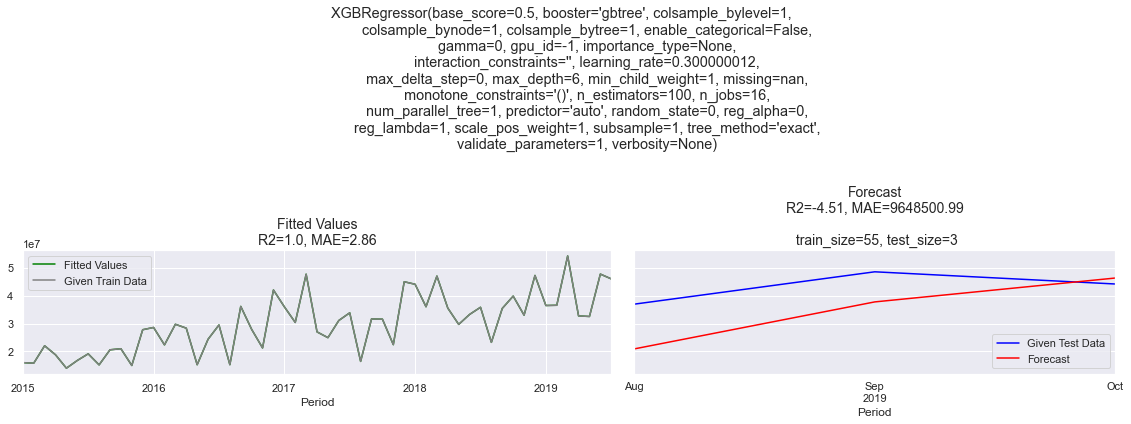

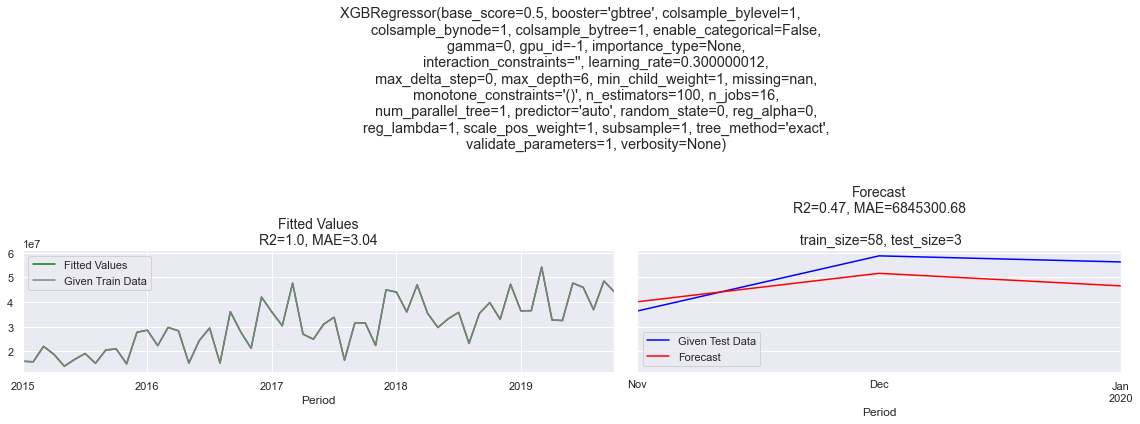

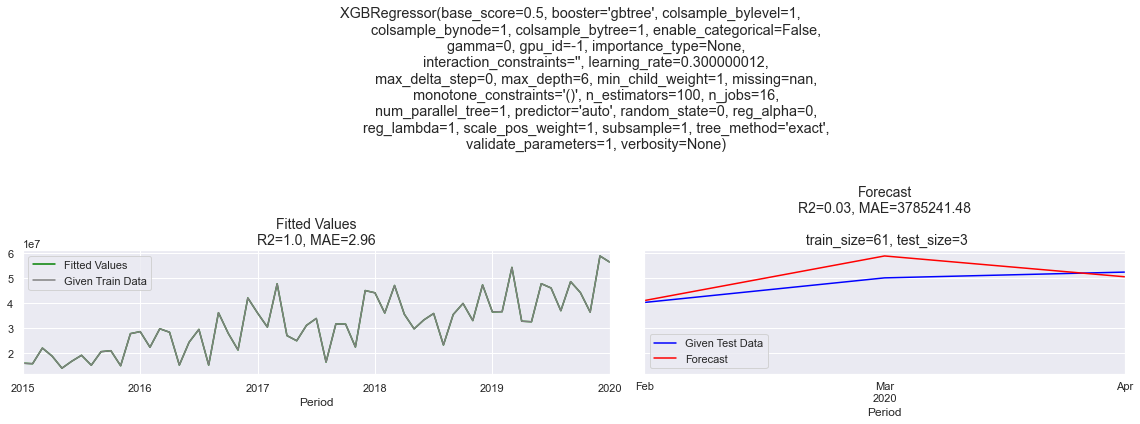

In [106]:
mod = XGBRegressor()
cross_validation(df2, mod, features,n_splits=4, target='Revenue', test_size=3)

## LGBMRegressor

R2score = -0.98, MAE = 8686097.56



(-0.9833425010548162, 8686097.556613417)

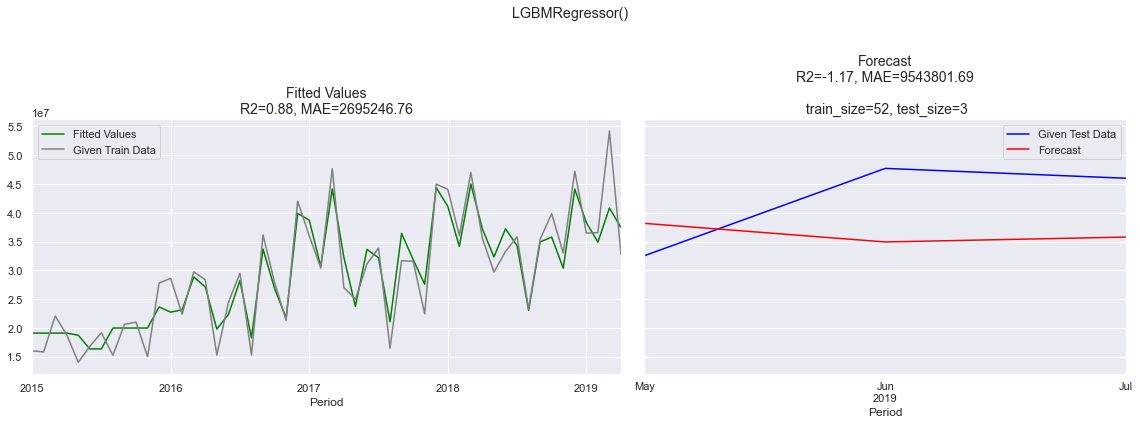

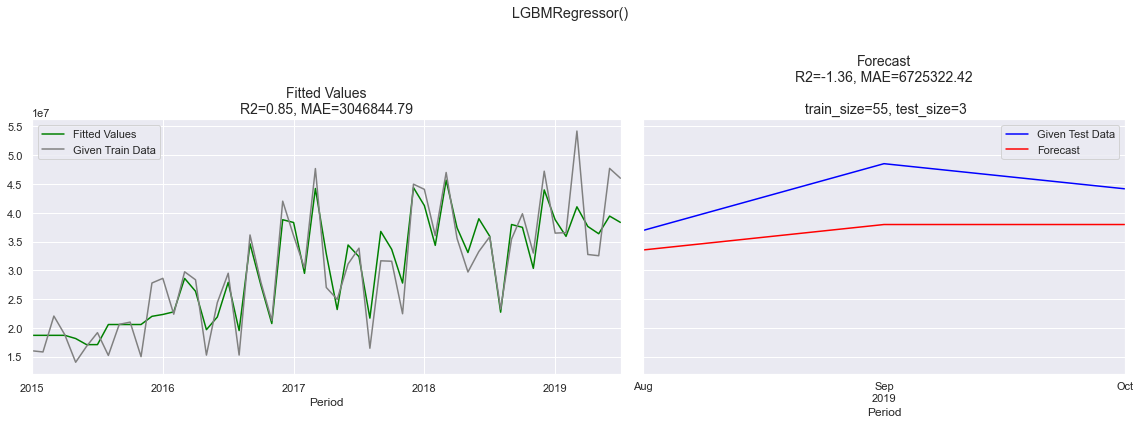

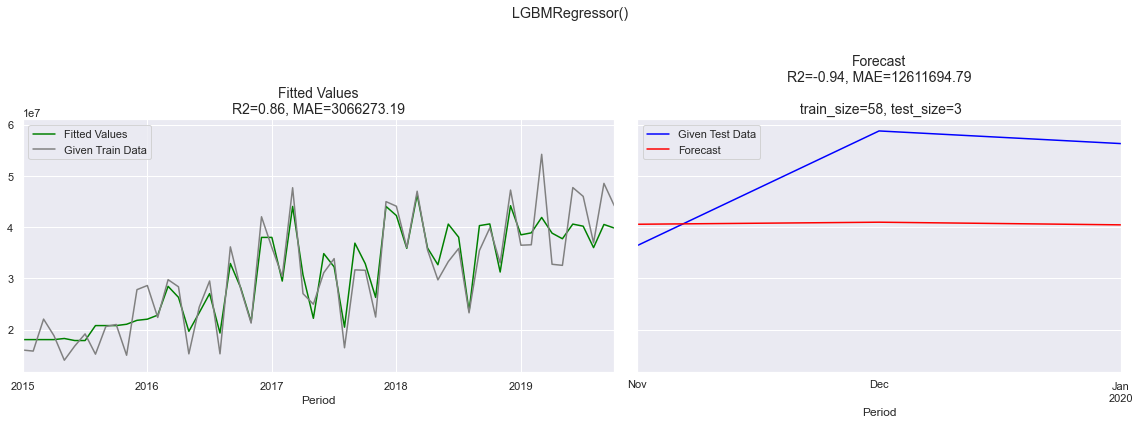

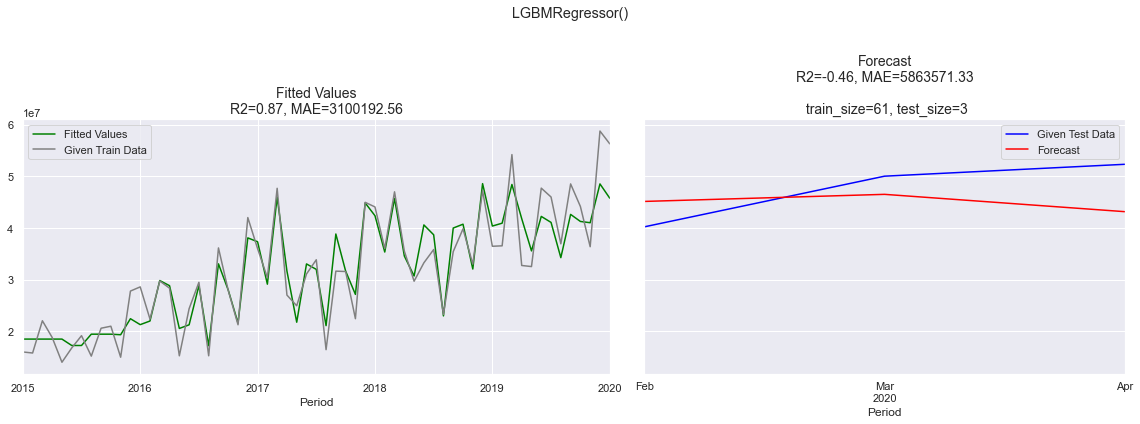

In [107]:
mod = LGBMRegressor()
cross_validation(df2, mod, features,n_splits=4, target='Revenue', test_size=3)

## Forecast for 1 Year (12 Month)

features

In [118]:
features = ['Month',
 'Season',
 'i-3',
 'i-4',
 'i-5',
 'i-6',
 'i-7',
 'i-8',
 'i-9',
 'i-10',
 'i-11',
 'i-12']

In [119]:
#df2.dropna(subset=features)

R2score = -0.08, MAE = 6360199.13



(-0.08097514930052896, 6360199.126705216)

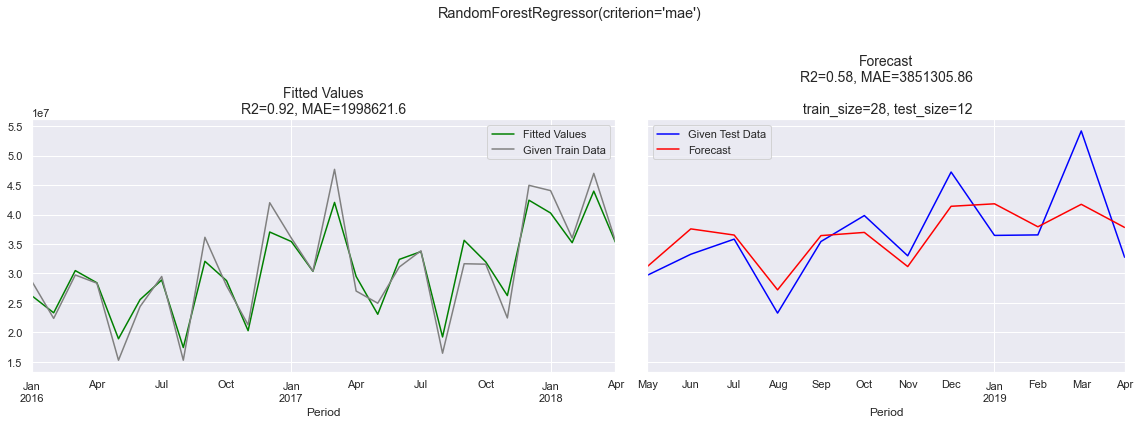

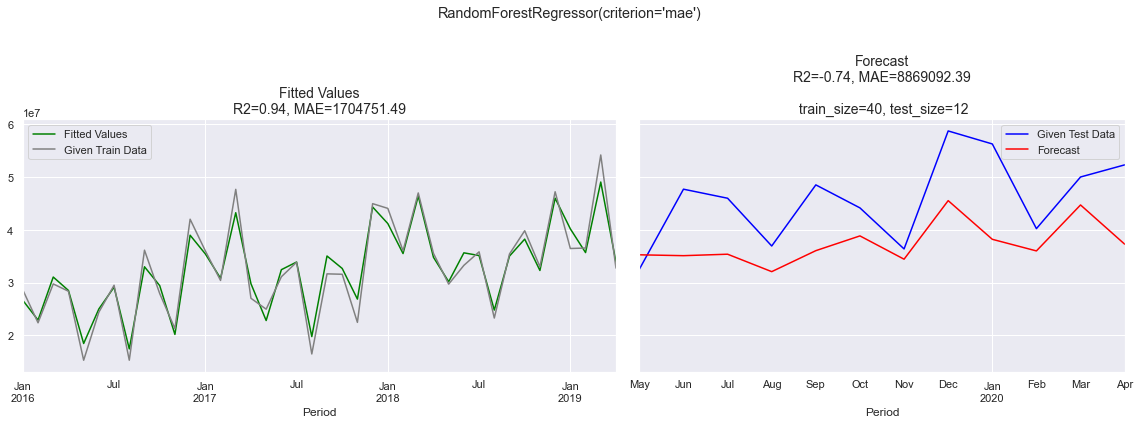

In [120]:
mod =RandomForestRegressor(criterion='mae')

cross_validation(df2.dropna(subset=features), mod, features,n_splits=2, target='Revenue', test_size=12)